In [2]:
averaged_entropy = {}
import matplotlib.pyplot as plt
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#930157', '#009966', '#72dfd9', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
         '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#930157', '#009966', '#72dfd9', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# !pip install mne
import mne
import os

In [253]:
import numpy as np
import itertools
def permutation_entropy(time_series, m, delay):
    """Calculate the Permutation Entropy
 
    Args:
        time_series: Time series for analysis
        m: Order of permutation entropy
        delay: Time delay
 
    Returns:
        Vector containing Permutation Entropy
 
    Reference:
        [1] Massimiliano Zanin et al. Permutation Entropy and Its Main Biomedical and Econophysics Applications:
            A Review. http://www.mdpi.com/1099-4300/14/8/1553/pdf
        [2] Christoph Bandt and Bernd Pompe. Permutation entropy — a natural complexity
            measure for time series. http://stubber.math-inf.uni-greifswald.de/pub/full/prep/2001/11.pdf
        [3] http://www.mathworks.com/matlabcentral/fileexchange/37289-permutation-entropy/content/pec.m
    """
    n = len(time_series)
    permutations = np.array(list(itertools.permutations(range(m))))
    c = [0] * len(permutations)
 
    for i in range(n - delay * (m - 1)):
        # sorted_time_series =    np.sort(time_series[i:i+delay*m:delay], kind='quicksort')
        sorted_index_array = np.array(np.argsort(time_series[i:i + delay * m:delay], kind='quicksort'))
        for j in range(len(permutations)):
            if abs(permutations[j] - sorted_index_array).any() == 0:
                c[j] += 1
 
    c = [element for element in c if element != 0]
    p = np.divide(np.array(c), float(sum(c)))
    pe = -sum(p * np.log(p))/np.log(np.math.factorial(m))
    return pe

def signal_wise_entropy( fs, signal, window_duration, m, lag):
        number_of_periods = len(signal) // fs
        signal_entropy = []
        for starting_period in range(number_of_periods):
            signal_ = signal[starting_period * fs:(starting_period + window_duration) * fs]
            entropy = permutation_entropy(signal_, m, lag)
            signal_entropy.append(entropy)
        print("Length of resulting signal entropy:", len(signal_entropy))
        return signal_entropy
    
class EEG_sample:
    def __init__(self, file, seizure_times):
        self.file = file
        self.raw = mne.io.read_raw_edf(file)
        self.raw_data = self.raw.get_data()
        # you can get the metadata included in the file and a list of all channels:
        self.info = self.raw.info
        self.channels = self.raw.ch_names
        self.fs = 256
        self.seizure_time = seizure_times
        self.window_before = 100
        self.window_after = 50
        self.averaged_entropy={}


    def plot_part_of_signal(self, time):
        '''
        Plots an EEG signal for only 13 sources.
        :param time: int, sec of signal to plot
        :return: None
        '''
        self.raw.plot(duration=time, n_channels=len(self.channels) // 2)

    # def plot_psd(...):

    def preprocess(self, l_freq = 1., h_freq = None, n_components = 15, random_state = 70):
        filt_raw = self.raw.copy()
        filt_raw.load_data().filter(l_freq=l_freq, h_freq=h_freq)
        ica = mne.preprocessing.ICA(n_components=n_components, random_state=random_state)
        ica.fit(filt_raw)
        self.raw.load_data()
        ica.plot_sources(self.raw)

    @staticmethod
    def permutation_entropy(time_series, m, delay):
        """Calculate the Permutation Entropy

        Args:
            time_series: Time series for analysis
            m: Order of permutation entropy
            delay: Time delay

        Returns:
            Vector containing Permutation Entropy

        Reference:
            [1] Massimiliano Zanin et al. Permutation Entropy and Its Main Biomedical and Econophysics Applications:
                A Review. http://www.mdpi.com/1099-4300/14/8/1553/pdf
            [2] Christoph Bandt and Bernd Pompe. Permutation entropy — a natural complexity
                measure for time series. http://stubber.math-inf.uni-greifswald.de/pub/full/prep/2001/11.pdf
            [3] http://www.mathworks.com/matlabcentral/fileexchange/37289-permutation-entropy/content/pec.m
        """
        n = len(time_series)
        permutations = np.array(list(itertools.permutations(range(m))))
        c = [0] * len(permutations)

        for i in range(n - delay * (m - 1)):
            # sorted_time_series =    np.sort(time_series[i:i+delay*m:delay], kind='quicksort')
            sorted_index_array = np.array(np.argsort(time_series[i:i + delay * m:delay], kind='quicksort'))
            for j in range(len(permutations)):
                if abs(permutations[j] - sorted_index_array).any() == 0:
                    c[j] += 1

        c = [element for element in c if element != 0]
        p = np.divide(np.array(c), float(sum(c)))
        pe = -sum(p * np.log(p)) / np.log(np.math.factorial(m))
        return pe
    

    def get_permutation_entropy_all_channels(self, window_duration, m, lag):

        permutation_en = []
        
        count_start = (self.seizure_time[0] - self.window_before) * self.fs
        count_end = (self.seizure_time[1] + self.window_after) * self.fs
#         print("Self.raw_data",len(self.raw_data[0]), count_start, count_end)
        
        for s in range(len(self.channels)):
            print('Channel:', s, self.channels[s])
            signal = self.raw_data[s][count_start:count_end]
            
            fs = self.fs
            signal_entropy = signal_wise_entropy(fs, signal, window_duration, m, lag)
      
            time_ = np.linspace(self.seizure_time[0] - self.window_before, self.seizure_time[1] + self.window_after, len(signal_entropy))

#             fig = plt.figure(figsize=(30, 10))

#             plt.plot(time_, signal_entropy, COLORS[s], label="Channel "+self.channels[s])
#             plt.xlabel('Time, s', fontsize=18)
#             plt.ylabel('Entropy', fontsize=18)
#             plt.title('Permutation entropy as a function of time '+str(self.seizure_time), weight='bold', fontsize=35)
#             plt.legend(fontsize='xx-large')
#             plt.show()
#             print("signal_entropy",signal_entropy)
            permutation_en.append(signal_entropy)

        return permutation_en

    def get_averaged_permutation_entropy(self, window_duration, m, lag):
        
        if 'window='+str(window_duration)+', m='+str(m)+', lag='+str(lag) not in self.averaged_entropy.keys():
            print("Getting averaged for "+self.file)
            
            averaged_permutation_en = []
            permutation_en =  self.get_permutation_entropy_all_channels( window_duration, m, lag)

            for a in range(len(permutation_en[0])):
                value = []
                for vector in permutation_en:
                    value.append(vector[a])
                averaged_permutation_en.append(sum(value) / len(value))
        else:
            print("There is a ready")
            key = 'window='+str(window_duration)+', m='+str(m)+', lag='+str(lag)
            averaged_permutation_en = self.averaged_entropy[key]
            

        return averaged_permutation_en

    def plot_permutation_entropy(self, entropy):

        time_ = np.arange(self.seizure_time[0] - self.window_before, self.seizure_time[1] + self.window_after, 1)

        fig = plt.figure(figsize=(30, 10))

        for i, e in enumerate(entropy):

            plt.plot(time_, e, COLORS[8], label="Channel "+str(i))

        plt.xlabel('Time, s', fontsize=18)
        plt.ylabel('Entropy', fontsize=18)
        plt.title('Permutation entropy as a function of time', weight='bold', fontsize=35)
        plt.legend(fontsize='xx-large')
        return plt.show()
    
    
    

In [254]:
# !pip install mne
import mne
import os
# from 
DIR_ = "/Users/sofiyagarkot/Desktop/Signals/coursework/test_data/"
os.chdir(DIR_)

raws_correspond = {'chb15':{'chb15_40':[[834,894], [2378,2497], [3362, 3425]], 'chb15_15': [[1591,1748]], 
                            'chb15_22':[[760,965]], 'chb15_49':[[1108, 1248]],
                        'chb15_20':[[607,662]], 'chb15_17':[[1925,1960]], 'chb15_28':[[876,1066]], 
                            'chb15_62':[[751, 859]], 'chb15_46':[[3322,3429]], 
                        'chb15_54':[[263,318], [843, 1020], [1524, 1595], [2179, 2250], [3428, 3460]], 
                            'chb15_31':[[1751,1871]], 'chb15_52':[[778, 849]], 
                            'chb15_10':[[1082,1113]], 'chb15_06':[[272, 397]]},
                  'chb09':{'chb09_08':[[2951, 3030], [9196, 9267]], 'chb09_19':[[5299, 5361]], 'chb09_06':[[12231,12295]]},
                  'chb23':{'chb23_09':[[2589, 2660], [6885, 6947], [8505, 8532], [9580, 9664]], 
                           'chb23_06':[[3962, 4075]], 'chb23_08':[[325, 345], [5104, 5151]]},
                  'chb06':{'chb06_13':[[506,519]], 'chb06_04':[[327, 347], [6211, 6231]], 'chb06_24':[[9387, 9403]], 
                           'chb06_01':[[1724,1738],[7461, 7476], [13525, 13540]], 'chb06_18':[[7799, 7811]],
                          'chb06_10':[[10833, 10845]], 'chb06_09':[[12500, 12516]]},
                  'chb01':{'chb01_03':[[2996, 3036]], 'chb01_04':[[1467,1494]], 'chb01_15':[[1732, 1772]],
                      'chb01_16':[[1015, 1066]], 'chb01_18':[[1720,1810]], 'chb01_21':[[327, 420]], 'chb01_26':[[1862, 1963]]},
                  'chb20':{'chb20_12':[[94, 123]], 'chb20_13':[[1440, 1470], [2498, 2537]], 'chb20_14':[[1971, 2009]],
                          'chb20_15':[[390, 425], [1689,1738]], 'chb20_16':[[2226, 2261]], 'chb20_68':[[1393, 1432]]}
                  }


samples = []

for d in os.listdir():
    if d in raws_correspond.keys():
        print(d)
        os.chdir(DIR_+"/"+d)
        for file in os.listdir():
            print(file)
            if file[:-4] in raws_correspond[d].keys():
                for part_of_signal in raws_correspond[d][file[:-4]]:
                    print("part_of_signal",part_of_signal)
                    eeg_sample = EEG_sample(file, part_of_signal)
                    samples.append(eeg_sample)
    
            elif file[6:-4] in raws_correspond[d].keys():
                for part_of_signal in raws_correspond[d][file[6:-4]]:
                    print("part_of_signal",part_of_signal)
                    eeg_sample = EEG_sample(file, part_of_signal)
                    samples.append(eeg_sample)



chb20
chb20-chb20_15.edf.seizures
chb20-chb20_12.edf.seizures
chb20-chb20_13.edf.seizures
chb20-chb20_14.edf.seizures
chb20-chb20_68.edf.seizures
chb20-chb20_68.edf
part_of_signal [1393, 1432]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb20/chb20-chb20_68.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb20-chb20_13.edf
part_of_signal [1440, 1470]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb20/chb20-chb20_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [2498, 2537]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb20/chb20-chb20_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb20-chb20_16.edf.seizures
chb20-chb20_12.edf
part_of_signal [94, 123]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb20/chb20-chb20_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb20-chb20_16.edf
part_of_signal [2226, 2261]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb20/chb20-chb20_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb20-chb20_15.edf
part_of_signal [390, 425]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb20/chb20-chb20_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [1689, 1738]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb20/chb20-chb20_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb20-chb20_14.edf
part_of_signal [1971, 2009]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb20/chb20-chb20_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'.', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb15
chb15-chb15_40.edf
part_of_signal [834, 894]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [2378, 2497]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [3362, 3425]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_20.edf.seizures
chb15-chb15_10.edf.seizures
chb15-chb15_17.edf.seizures
chb15-chb15_52.edf
part_of_signal [778, 849]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_52.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_46.edf
part_of_signal [3322, 3429]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_20.edf
part_of_signal [607, 662]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_22.edf
part_of_signal [760, 965]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_31.edf
part_of_signal [1751, 1871]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_49.edf.seizures
chb15-chb15_15.edf
part_of_signal [1591, 1748]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_28.edf.seizures
chb15-chb15_28.edf
part_of_signal [876, 1066]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_17.edf
part_of_signal [1925, 1960]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_06.edf
part_of_signal [272, 397]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_10.edf
part_of_signal [1082, 1113]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_52.edf.seizures
chb15-chb15_40.edf.seizures
chb15-chb15_15.edf.seizures
chb15-chb15_49.edf
part_of_signal [1108, 1248]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb15/chb15-chb15_49.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)
<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  self.raw = mne.io.read_raw_edf(file)


chb15-chb15_31.edf.seizures
chb15-chb15_46.edf.seizures
chb15-chb15_06.edf.seizures
chb15-chb15_22.edf.seizures
chb23
chb23-chb23_06.edf.seizures
chb23-chb23_08.edf
part_of_signal [325, 345]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb23/chb23-chb23_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [5104, 5151]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb23/chb23-chb23_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb23-chb23_09.edf
part_of_signal [2589, 2660]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb23/chb23-chb23_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [6885, 6947]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb23/chb23-chb23_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [8505, 8532]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb23/chb23-chb23_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [9580, 9664]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb23/chb23-chb23_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb23-chb23_08.edf.seizures
chb23-chb23_09.edf.seizures
chb23-chb23_06.edf
part_of_signal [3962, 4075]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb23/chb23-chb23_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb09
chb09_19.edf
part_of_signal [5299, 5361]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb09/chb09_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb09_08.edf
part_of_signal [2951, 3030]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb09/chb09_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [9196, 9267]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb09/chb09_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


entropy_.txt
chb09_08.edf.seizures
chb09_19.edf.seizures
.ipynb_checkpoints
chb09_06.edf
part_of_signal [12231, 12295]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb09/chb09_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb09_06.edf.seizures
chb09_02.edf
chb01
chb01-chb01_18.edf
part_of_signal [1720, 1810]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb01/chb01-chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb01-chb01_26.edf
part_of_signal [1862, 1963]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb01/chb01-chb01_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb01-chb01_21.edf
part_of_signal [327, 420]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb01/chb01-chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb01-chb01_15.edf.seizures
chb01-chb01_18.edf.seizures
chb01-chb01_26.edf.seizures
chb01-chb01_21.edf.seizures
chb01-chb01_04.edf
part_of_signal [1467, 1494]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb01/chb01-chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb01-chb01_03.edf
part_of_signal [2996, 3036]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb01/chb01-chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb01-chb01_16.edf
part_of_signal [1015, 1066]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb01/chb01-chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb01-chb01_16.edf.seizures
chb01-chb01_15.edf
part_of_signal [1732, 1772]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb01/chb01-chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb01-chb01_03.edf.seizures
chb01-chb01_04.edf.seizures
chb06
chb06-chb06_04.edf
part_of_signal [327, 347]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [6211, 6231]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb06-chb06_10.edf
part_of_signal [10833, 10845]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb06-chb06_10.edf.seizures
chb06-chb06_13.edf
part_of_signal [506, 519]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb06-chb06_04.edf.seizures
chb06-chb06_01.edf
part_of_signal [1724, 1738]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [7461, 7476]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


part_of_signal [13525, 13540]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


entropy_window=1, m=4, lag=1.txt
chb06-chb06_09.edf.seizures
chb06-chb06_18.edf.seizures
chb06-chb06_18.edf
part_of_signal [7799, 7811]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb06-chb06_24.edf
part_of_signal [9387, 9403]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb06-chb06_13.edf.seizures
chb06-chb06_01.edf.seizures
chb06-chb06_09.edf
part_of_signal [12500, 12516]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb06/chb06-chb06_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-253-1b93fce85709>:50: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


chb06-chb06_24.edf.seizures


Sample: chb20-chb20_68.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498'])
In
There is a ready
Equals test True
chb20-chb20_68.edf1393


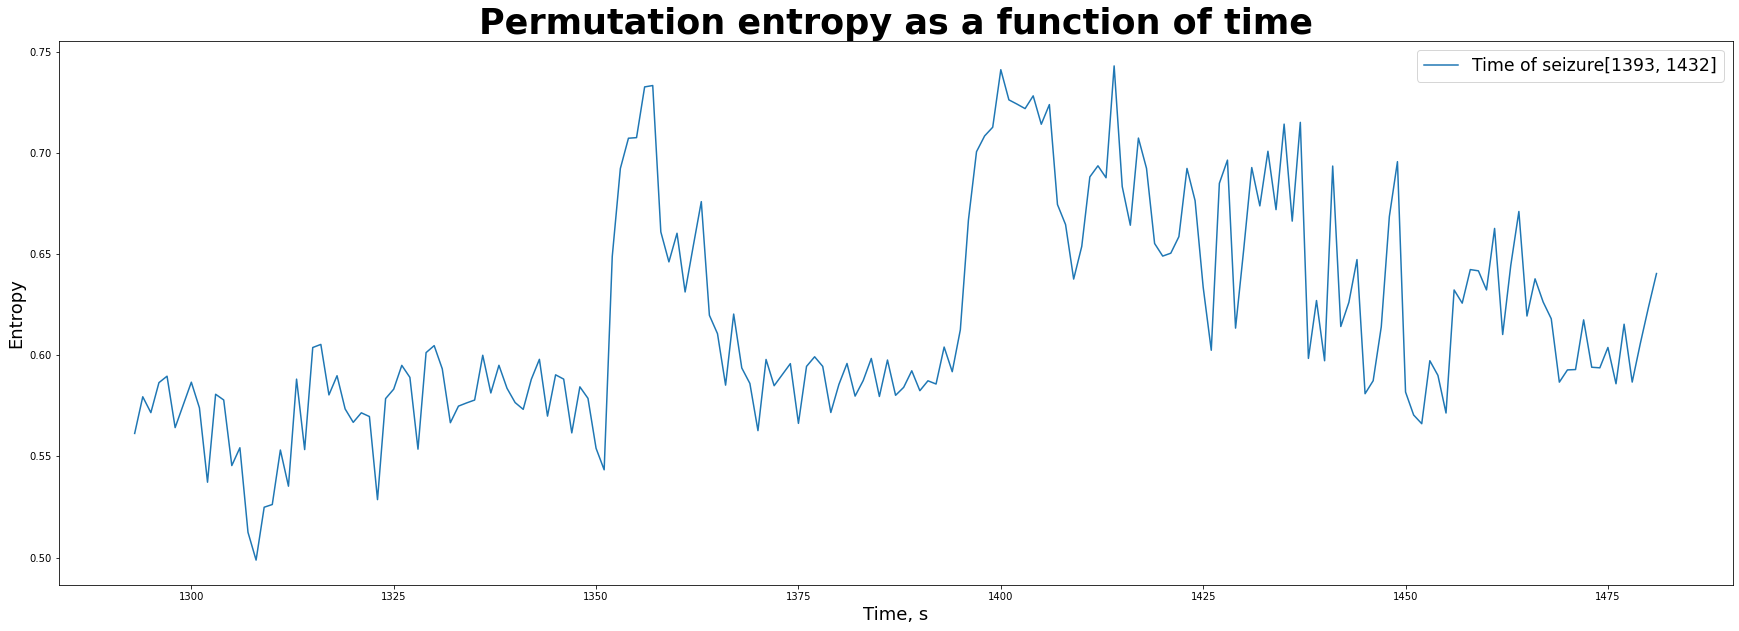

Sample: chb20-chb20_13.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498'])
In
There is a ready
Equals test True
chb20-chb20_13.edf1440


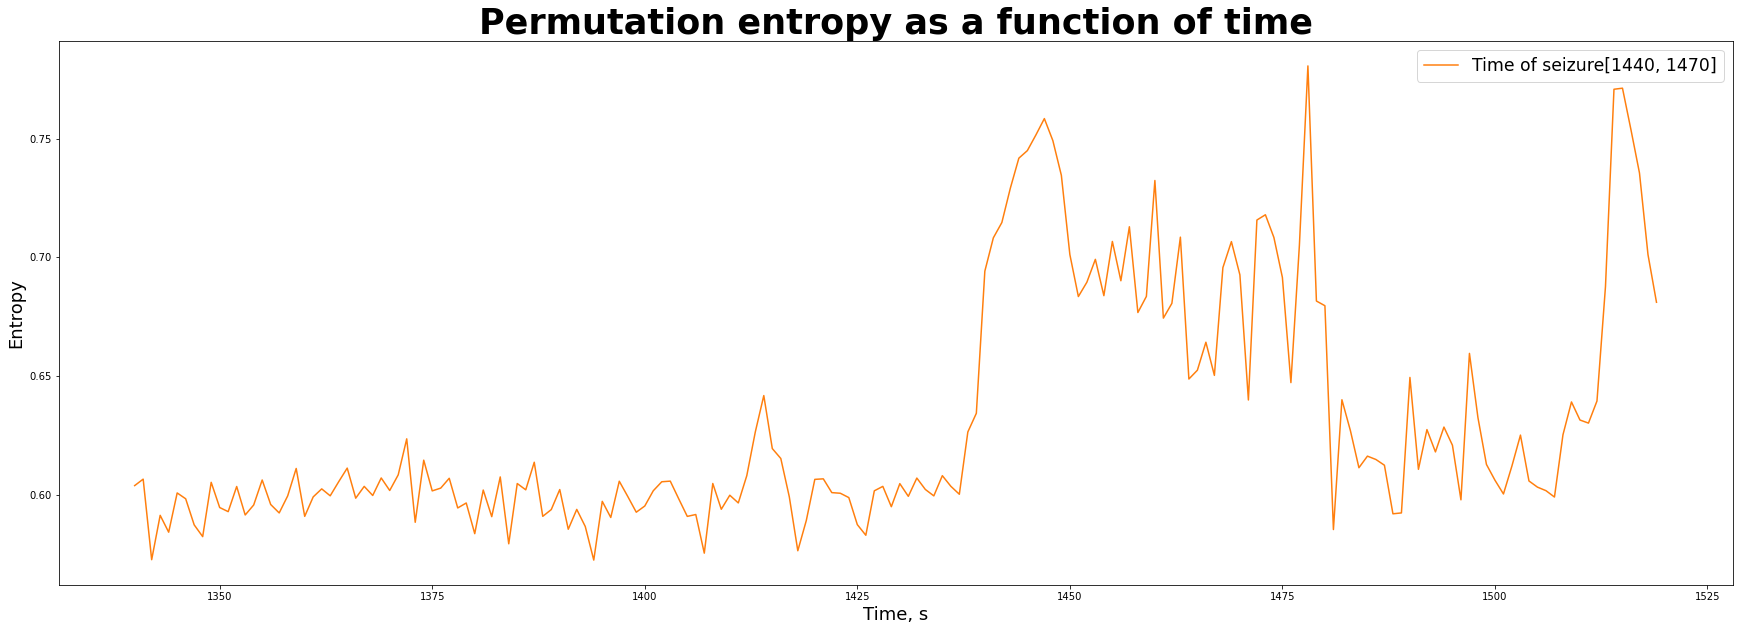

Sample: chb20-chb20_13.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498'])
In
There is a ready
Equals test True
chb20-chb20_13.edf2498
WEird error
189 180
Sample: chb20-chb20_12.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498'])
Not in chb20-chb20_12.edf
Getting averaged for chb20-chb20_12.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 0
Channel: 1 F7-T7
Length of resulting signal entropy: 0
Channel: 2 T7-P7
Length of resulting signal entropy: 0
Channel: 3 P7-O1
Length of resulting signal entropy: 0
Channel: 4 .-0
Length of resulting signal entropy: 0
Channel: 5 FP1-F3
Length of resulting signal entropy: 0
Channel: 6 F3-C3
Length of resulting signal entropy: 0
Channel: 7 C3-P3
Length of resulting signal entropy

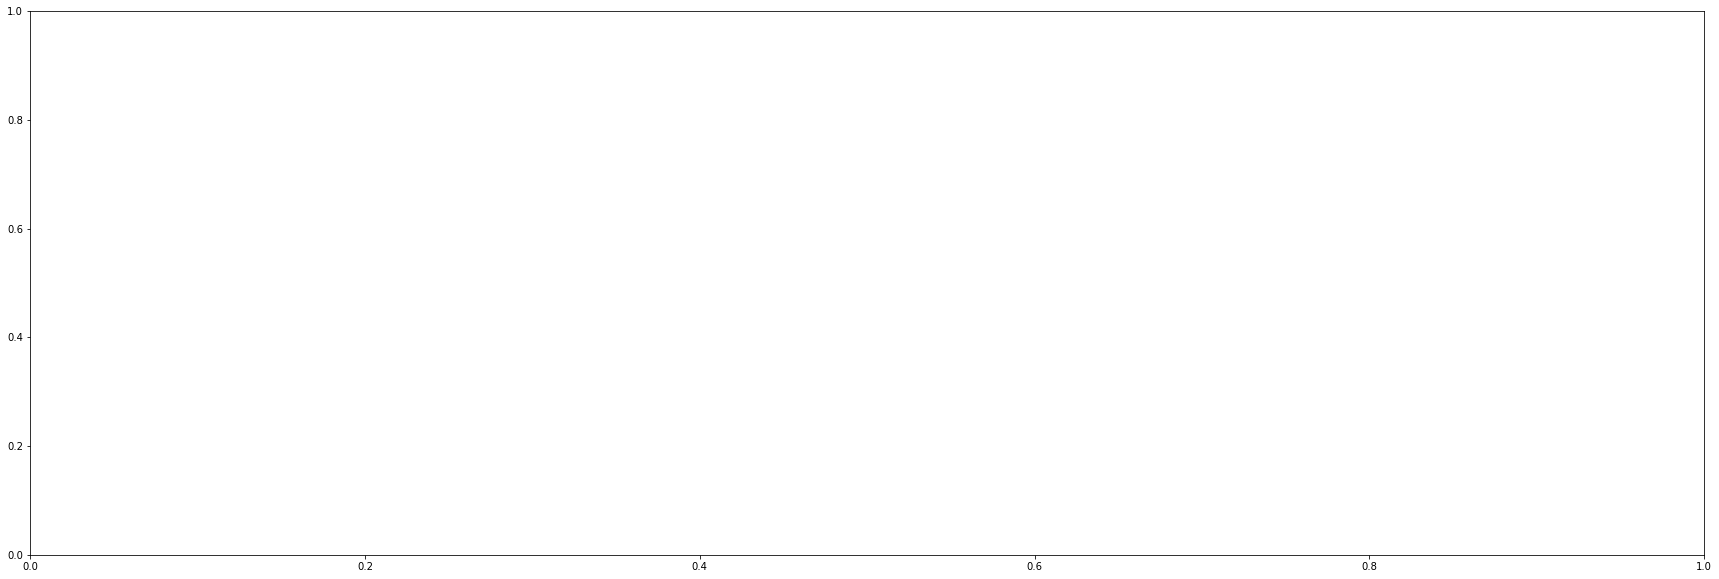

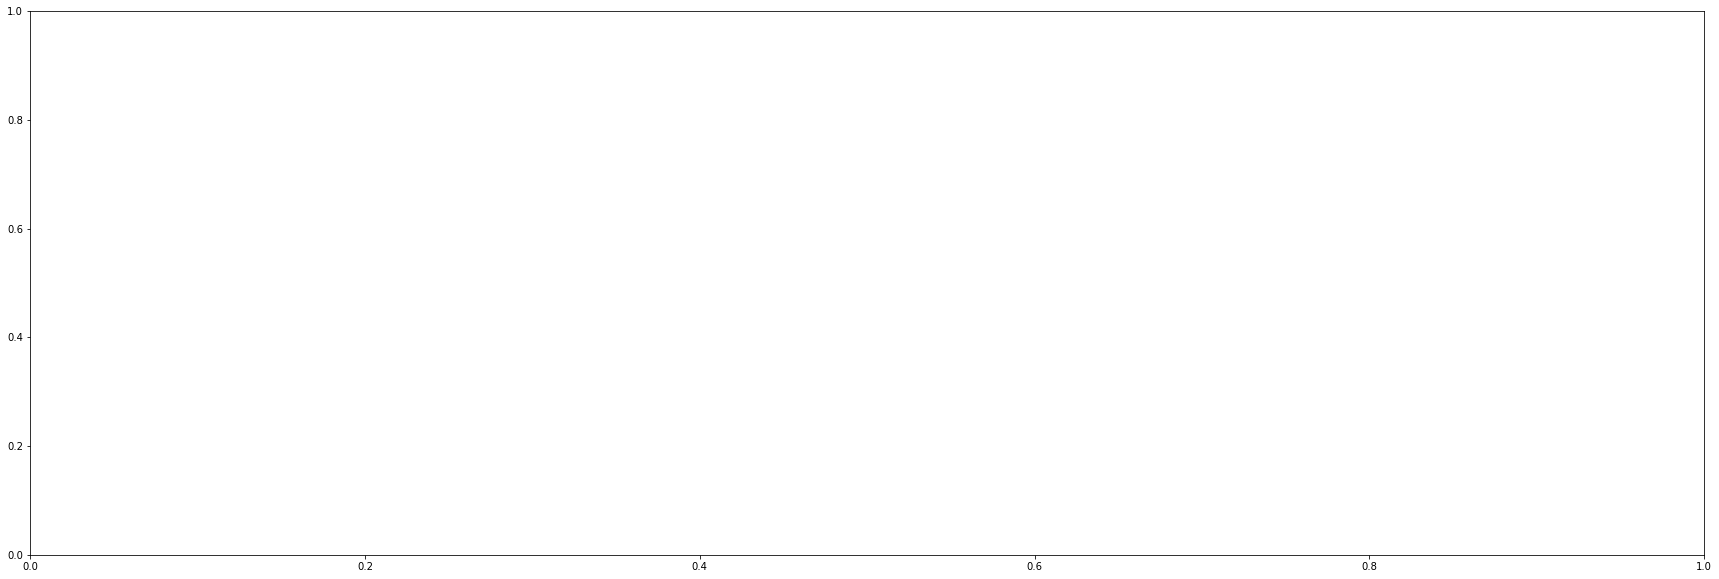

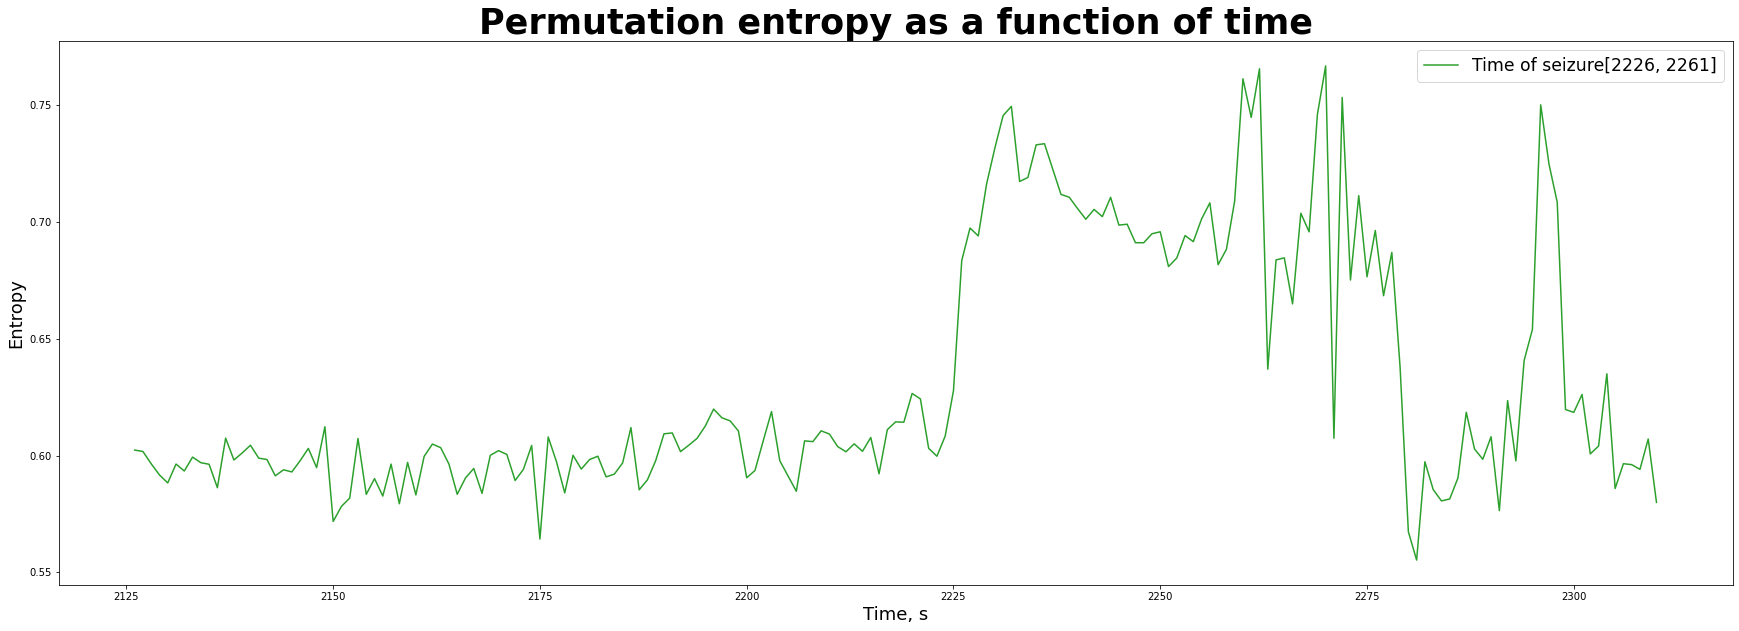

Sample: chb20-chb20_15.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226'])
Not in chb20-chb20_15.edf
Getting averaged for chb20-chb20_15.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 185
Channel: 1 F7-T7
Length of resulting signal entropy: 185
Channel: 2 T7-P7
Length of resulting signal entropy: 185
Channel: 3 P7-O1
Length of resulting signal entropy: 185
Channel: 4 .-0
Length of resulting signal entropy: 185
Channel: 5 FP1-F3
Length of resulting signal entropy: 185
Channel: 6 F3-C3
Length of resulting signal entropy: 185
Channel: 7 C3-P3
Length of resulting signal entropy: 185
Channel: 8 P3-O1
Length of resulting signal entropy: 185
Channel: 9 .-1
Length of resulting signal entropy: 185
Channel: 10 FZ-CZ
Length of resulting signal entropy: 185
Channel: 11 CZ-PZ
Length of resulting signal entr

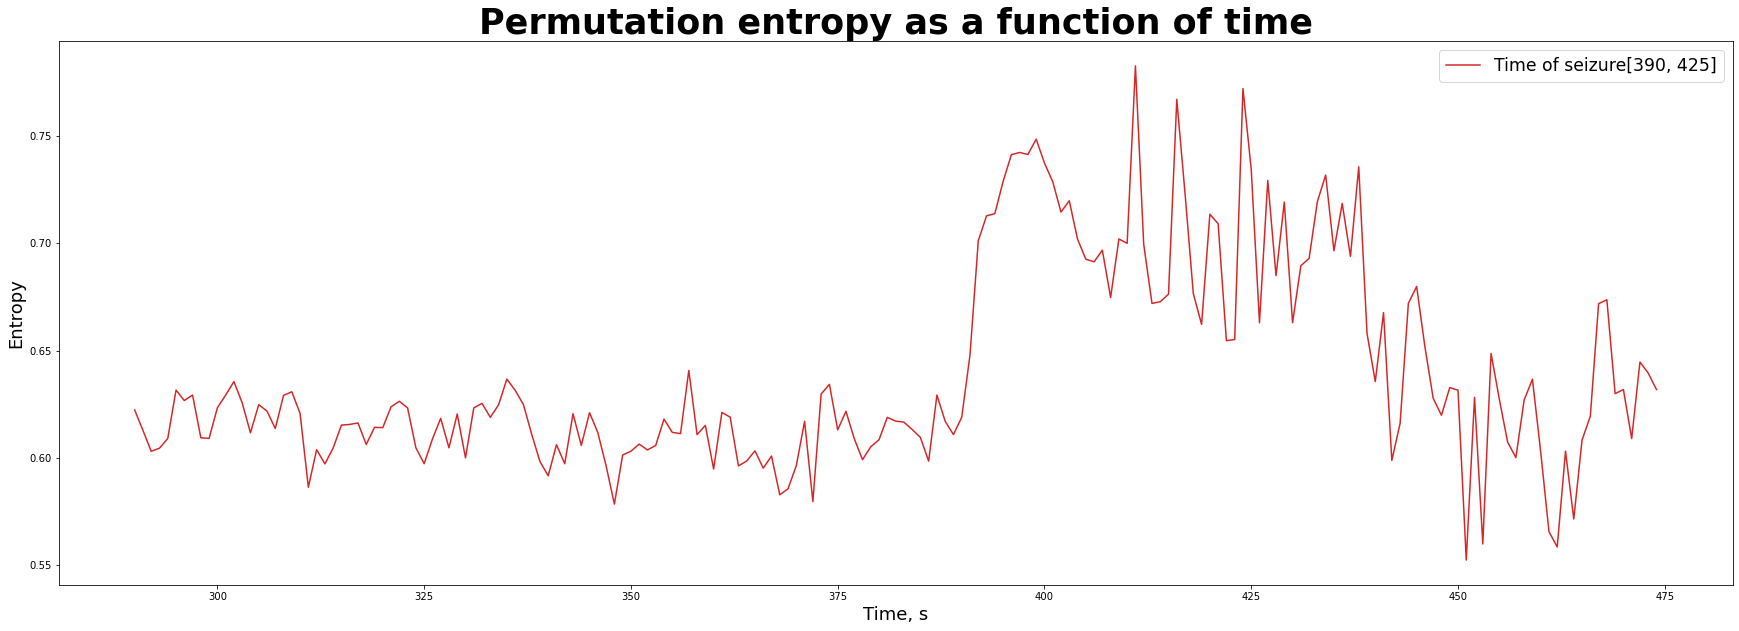

Sample: chb20-chb20_15.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390'])
Not in chb20-chb20_15.edf
Getting averaged for chb20-chb20_15.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 199
Channel: 1 F7-T7
Length of resulting signal entropy: 199
Channel: 2 T7-P7
Length of resulting signal entropy: 199
Channel: 3 P7-O1
Length of resulting signal entropy: 199
Channel: 4 .-0
Length of resulting signal entropy: 199
Channel: 5 FP1-F3
Length of resulting signal entropy: 199
Channel: 6 F3-C3
Length of resulting signal entropy: 199
Channel: 7 C3-P3
Length of resulting signal entropy: 199
Channel: 8 P3-O1
Length of resulting signal entropy: 199
Channel: 9 .-1
Length of resulting signal entropy: 199
Channel: 10 FZ-CZ
Length of resulting signal entropy: 199
Channel: 11 CZ-PZ
Length

Sample: chb20-chb20_14.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689'])
Not in chb20-chb20_14.edf
Getting averaged for chb20-chb20_14.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 188
Channel: 1 F7-T7
Length of resulting signal entropy: 188
Channel: 2 T7-P7
Length of resulting signal entropy: 188
Channel: 3 P7-O1
Length of resulting signal entropy: 188
Channel: 4 .-0
Length of resulting signal entropy: 188
Channel: 5 FP1-F3
Length of resulting signal entropy: 188
Channel: 6 F3-C3
Length of resulting signal entropy: 188
Channel: 7 C3-P3
Length of resulting signal entropy: 188
Channel: 8 P3-O1
Length of resulting signal entropy: 188
Channel: 9 .-1
Length of resulting signal entropy: 188
Channel: 10 FZ-CZ
Length of resulting signal entropy: 18

Sample: chb15-chb15_40.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971'])
Not in chb15-chb15_40.edf
Getting averaged for chb15-chb15_40.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 210
Channel: 1 F7-T7
Length of resulting signal entropy: 210
Channel: 2 T7-P7
Length of resulting signal entropy: 210
Channel: 3 P7-O1
Length of resulting signal entropy: 210
Channel: 4 --0
Length of resulting signal entropy: 210
Channel: 5 FP1-F3
Length of resulting signal entropy: 210
Channel: 6 F3-C3
Length of resulting signal entropy: 210
Channel: 7 C3-P3
Length of resulting signal entropy: 210
Channel: 8 P3-O1
Length of resulting signal entropy: 210
Channel: 9 --1
Length of resulting signal entropy: 210
Channel: 10 FZ-CZ
Length of re

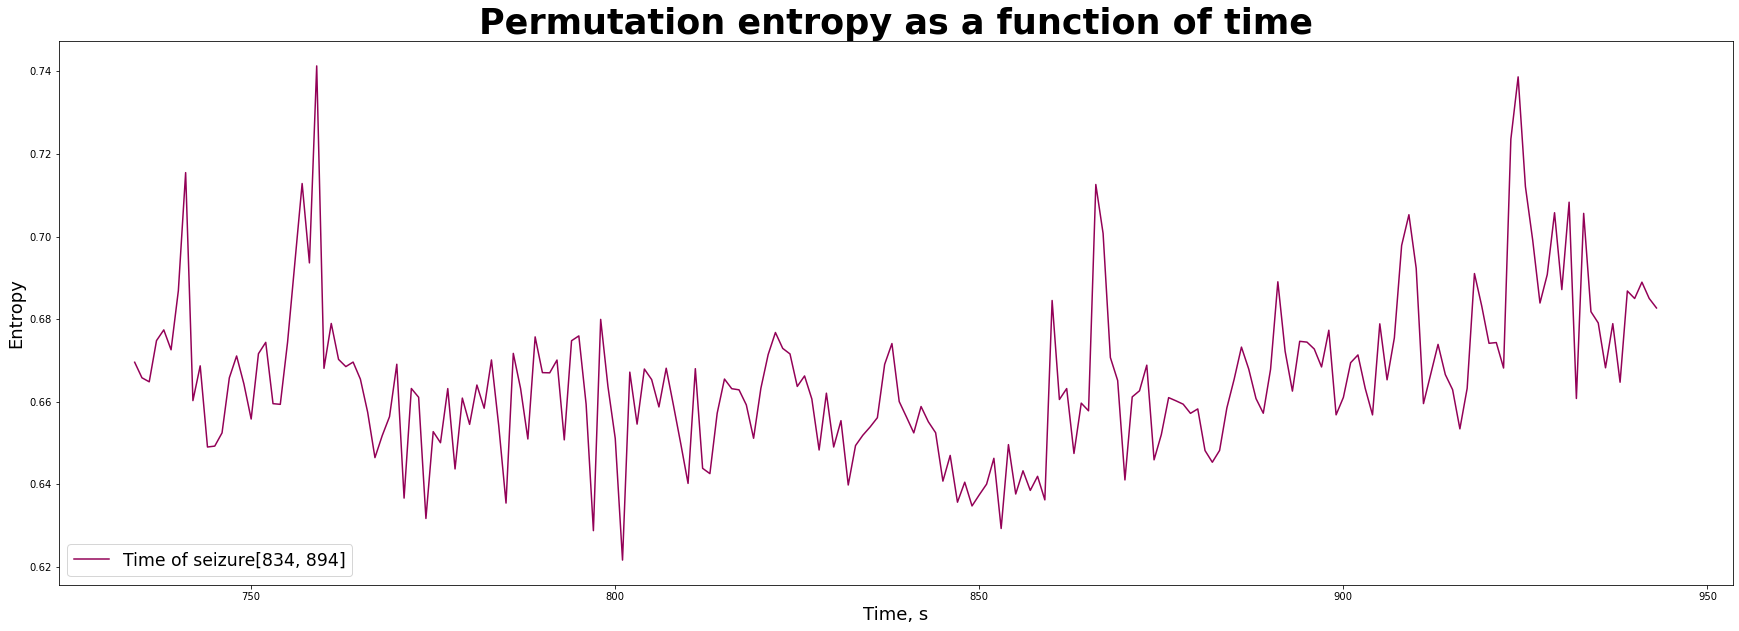

Sample: chb15-chb15_40.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834'])
Not in chb15-chb15_40.edf
Getting averaged for chb15-chb15_40.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 269
Channel: 1 F7-T7
Length of resulting signal entropy: 269
Channel: 2 T7-P7
Length of resulting signal entropy: 269
Channel: 3 P7-O1
Length of resulting signal entropy: 269
Channel: 4 --0
Length of resulting signal entropy: 269
Channel: 5 FP1-F3
Length of resulting signal entropy: 269
Channel: 6 F3-C3
Length of resulting signal entropy: 269
Channel: 7 C3-P3
Length of resulting signal entropy: 269
Channel: 8 P3-O1
Length of resulting signal entropy: 269
Channel: 9 --1
Length of resulting signal entropy: 269
Chann

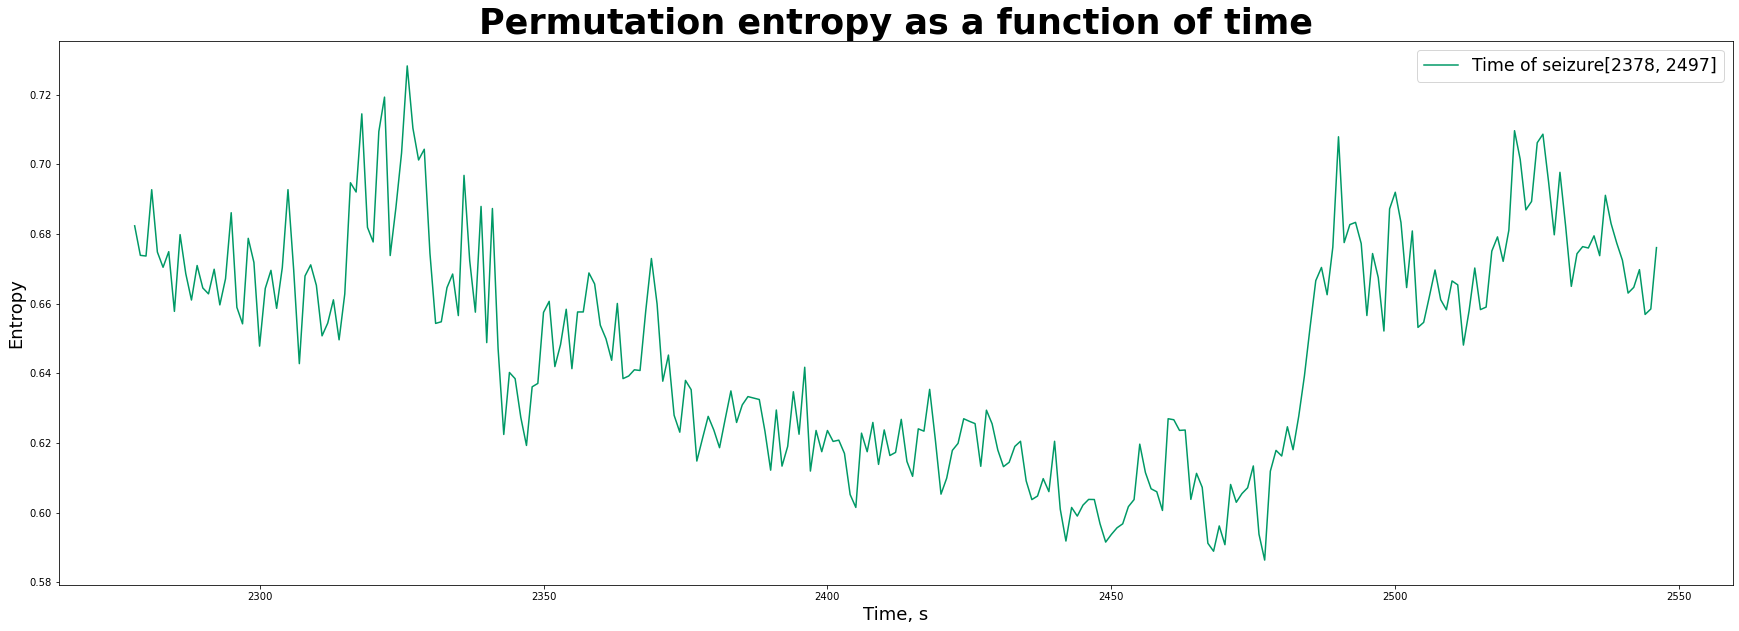

Sample: chb15-chb15_40.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378'])
Not in chb15-chb15_40.edf
Getting averaged for chb15-chb15_40.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 213
Channel: 1 F7-T7
Length of resulting signal entropy: 213
Channel: 2 T7-P7
Length of resulting signal entropy: 213
Channel: 3 P7-O1
Length of resulting signal entropy: 213
Channel: 4 --0
Length of resulting signal entropy: 213
Channel: 5 FP1-F3
Length of resulting signal entropy: 213
Channel: 6 F3-C3
Length of resulting signal entropy: 213
Channel: 7 C3-P3
Length of resulting signal entropy: 213
Channel: 8 P3-O1
Length of resulting signal entropy: 213
Channel: 9 --1
Length of resulting

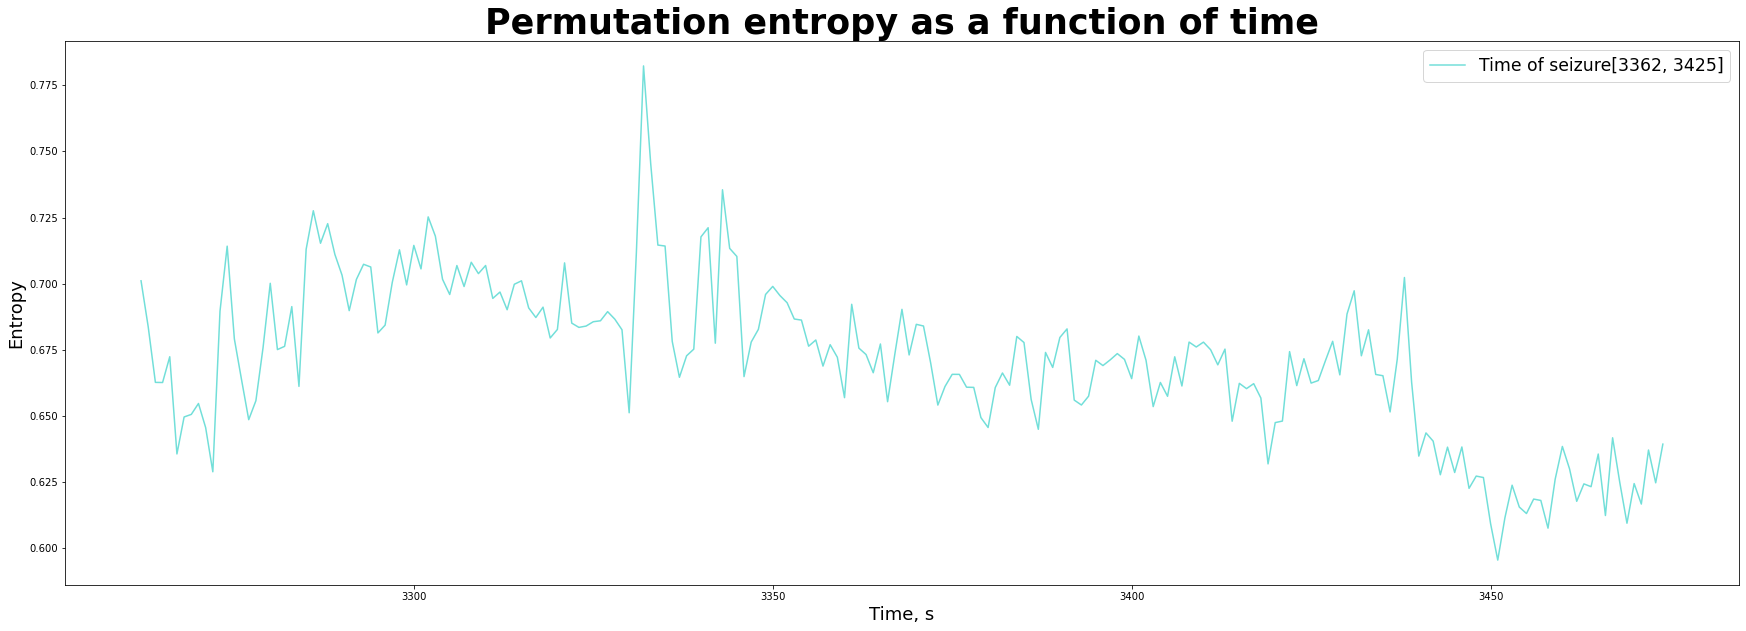

Sample: chb15-chb15_52.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362'])
Not in chb15-chb15_52.edf
Getting averaged for chb15-chb15_52.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 221
Channel: 1 F7-T7
Length of resulting signal entropy: 221
Channel: 2 T7-P7
Length of resulting signal entropy: 221
Channel: 3 P7-O1
Length of resulting signal entropy: 221
Channel: 4 --0
Length of resulting signal entropy: 221
Channel: 5 FP1-F3
Length of resulting signal entropy: 221
Channel: 6 F3-C3
Length of resulting signal entropy: 221
Channel: 7 C3-P3
Length of resulting signal entropy: 221
Channel: 8 P3-O1
Length of resulting signal entropy: 221
Channel:

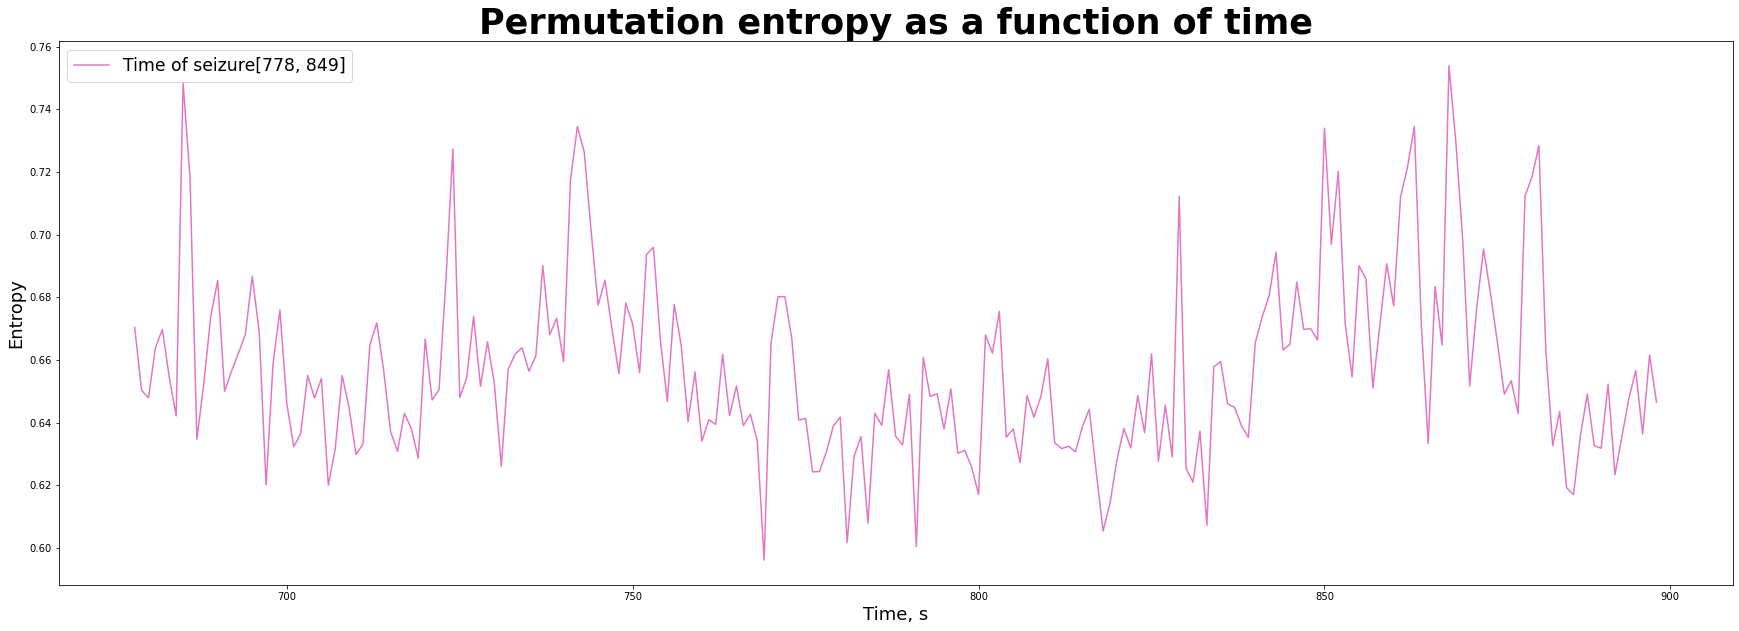

Sample: chb15-chb15_46.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778'])
Not in chb15-chb15_46.edf
Getting averaged for chb15-chb15_46.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 257
Channel: 1 F7-T7
Length of resulting signal entropy: 257
Channel: 2 T7-P7
Length of resulting signal entropy: 257
Channel: 3 P7-O1
Length of resulting signal entropy: 257
Channel: 4 --0
Length of resulting signal entropy: 257
Channel: 5 FP1-F3
Length of resulting signal entropy: 257
Channel: 6 F3-C3
Length of resulting signal entropy: 257
Channel: 7 C3-P3
Length of resulting signal entropy: 257
Channel: 8 P3-O1
Length of resulting sig

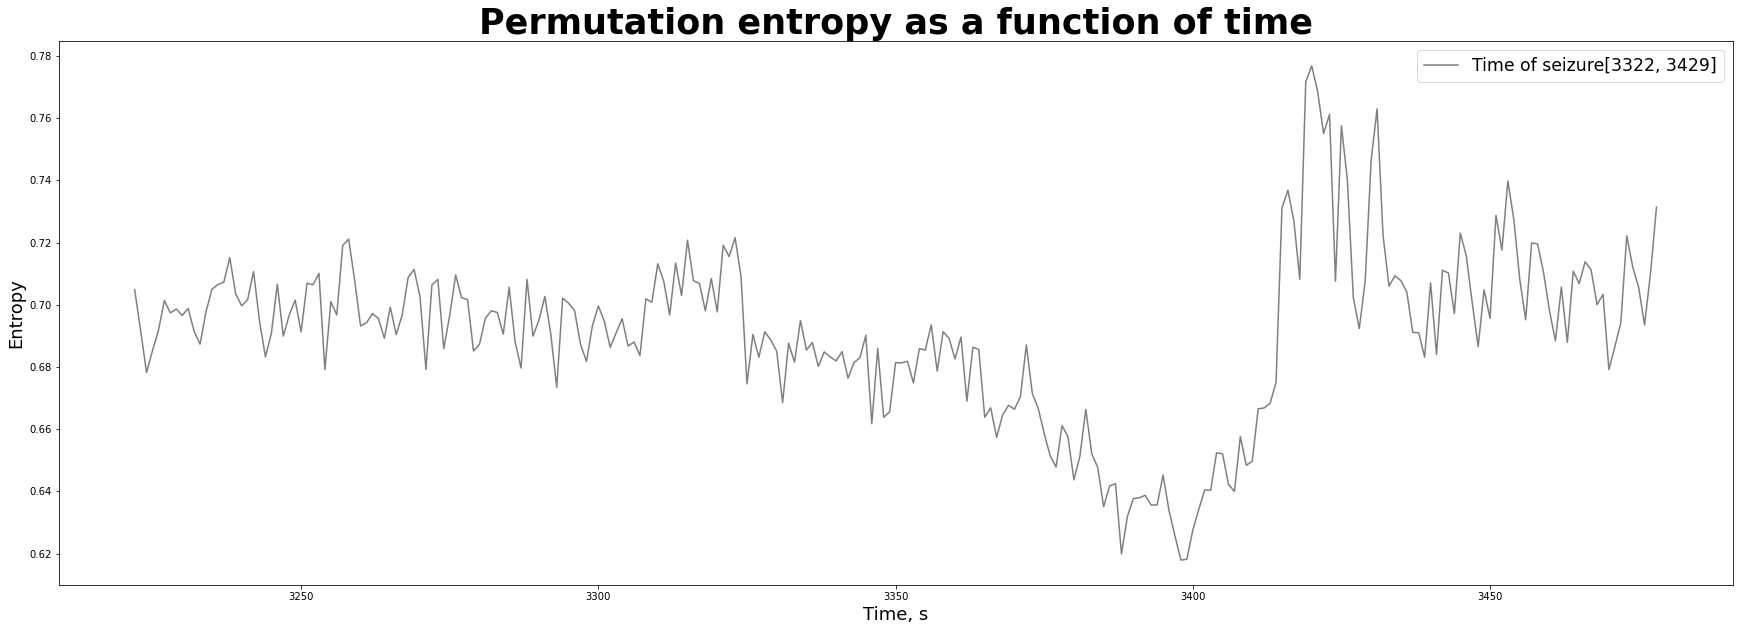

Sample: chb15-chb15_20.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322'])
Not in chb15-chb15_20.edf
Getting averaged for chb15-chb15_20.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 205
Channel: 1 F7-T7
Length of resulting signal entropy: 205
Channel: 2 T7-P7
Length of resulting signal entropy: 205
Channel: 3 P7-O1
Length of resulting signal entropy: 205
Channel: 4 --0
Length of resulting signal entropy: 205
Channel: 5 FP1-F3
Length of resulting signal entropy: 205
Channel: 6 F3-C3
Length of resulting signal entropy: 205
Channel: 7 C3-P3
Length of resulting signal entropy: 205
Channel: 8 P3-

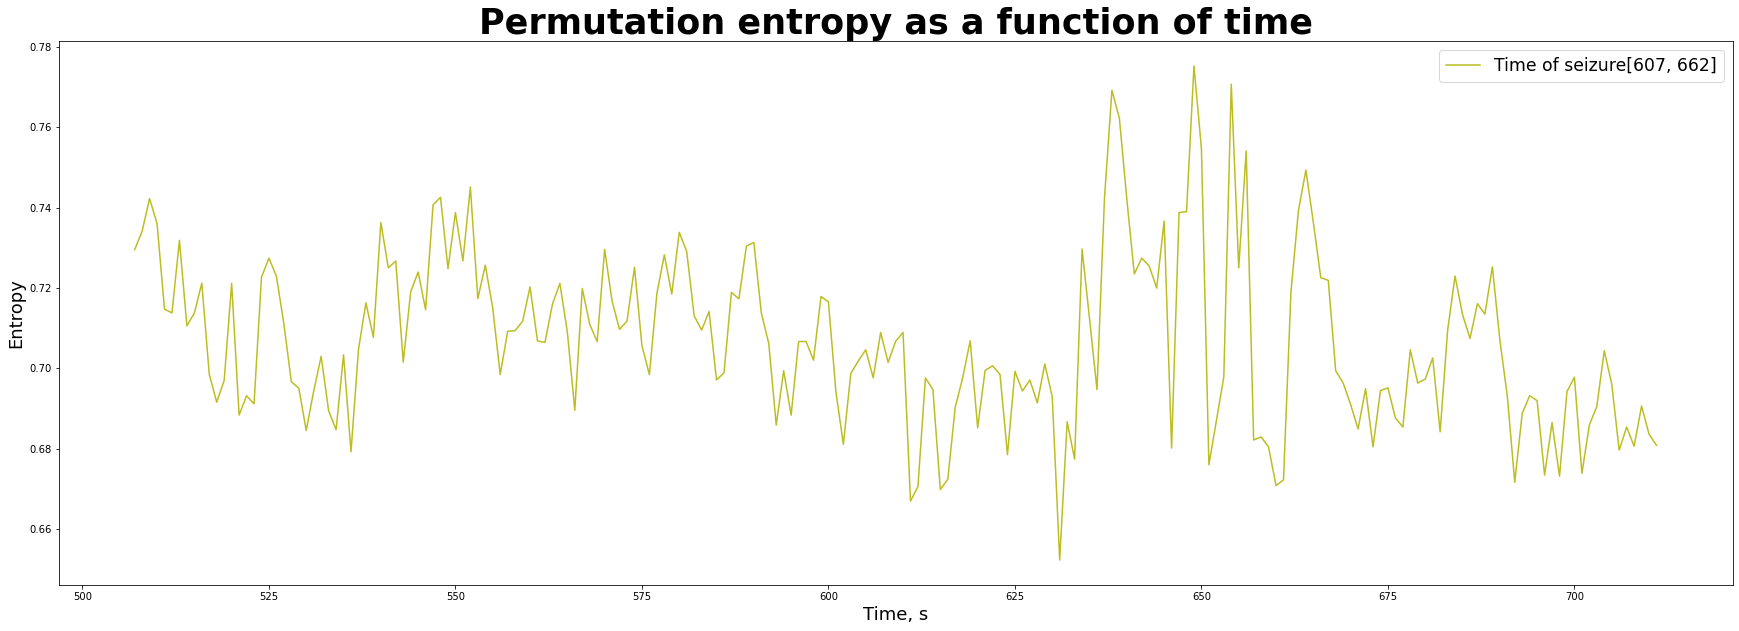

Sample: chb15-chb15_22.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607'])
Not in chb15-chb15_22.edf
Getting averaged for chb15-chb15_22.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 355
Channel: 1 F7-T7
Length of resulting signal entropy: 355
Channel: 2 T7-P7
Length of resulting signal entropy: 355
Channel: 3 P7-O1
Length of resulting signal entropy: 355
Channel: 4 --0
Length of resulting signal entropy: 355
Channel: 5 FP1-F3
Length of resulting signal entropy: 355
Channel: 6 F3-C3
Length of resulting signal entropy: 355
Channel: 7 C3-P3
Length of resulting signal en

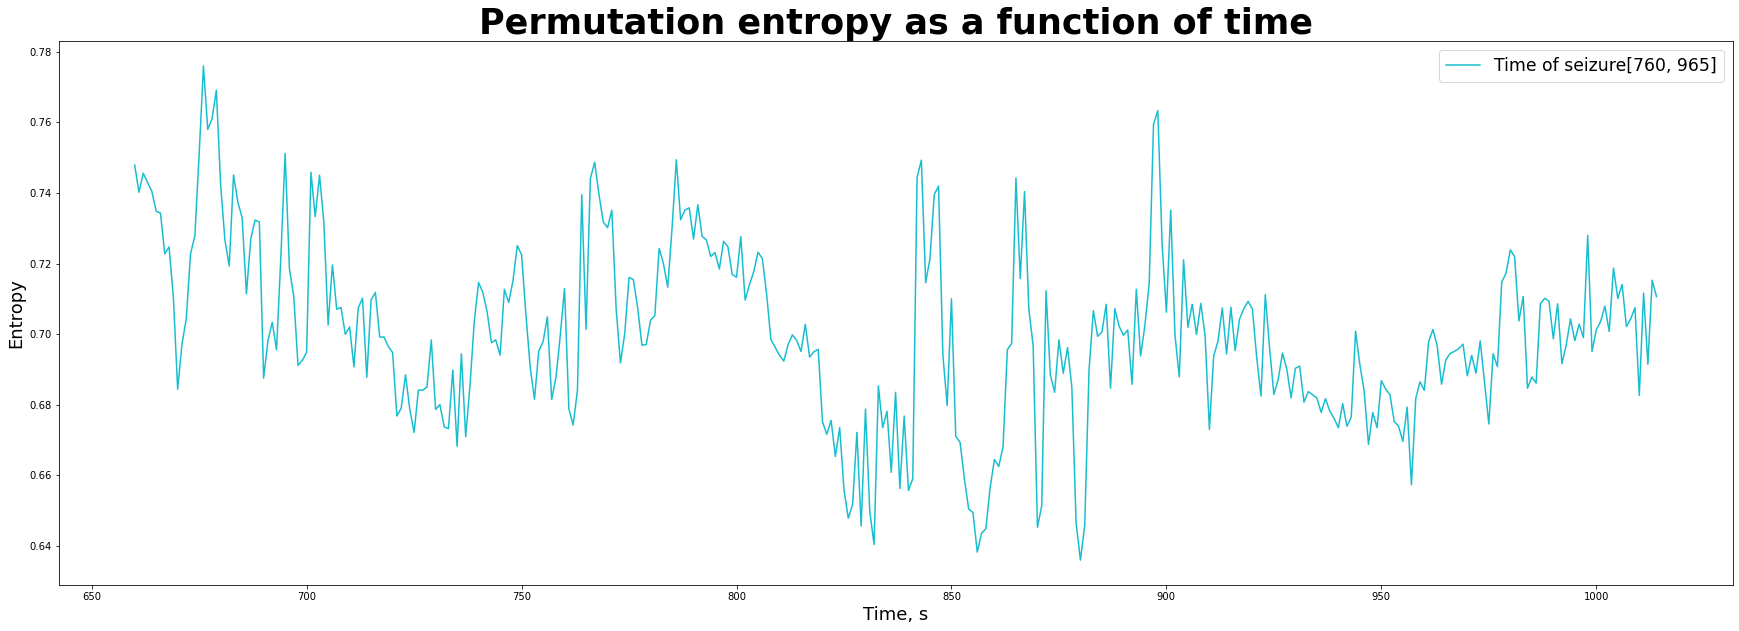

Sample: chb15-chb15_31.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760'])
Not in chb15-chb15_31.edf
Getting averaged for chb15-chb15_31.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 270
Channel: 1 F7-T7
Length of resulting signal entropy: 270
Channel: 2 T7-P7
Length of resulting signal entropy: 270
Channel: 3 P7-O1
Length of resulting signal entropy: 270
Channel: 4 --0
Length of resulting signal entropy: 270
Channel: 5 FP1-F3
Length of resulting signal entropy: 270
Channel: 6 F3-C3
Length of resulting signal entropy: 270
Channel: 7 C3-P3
Leng

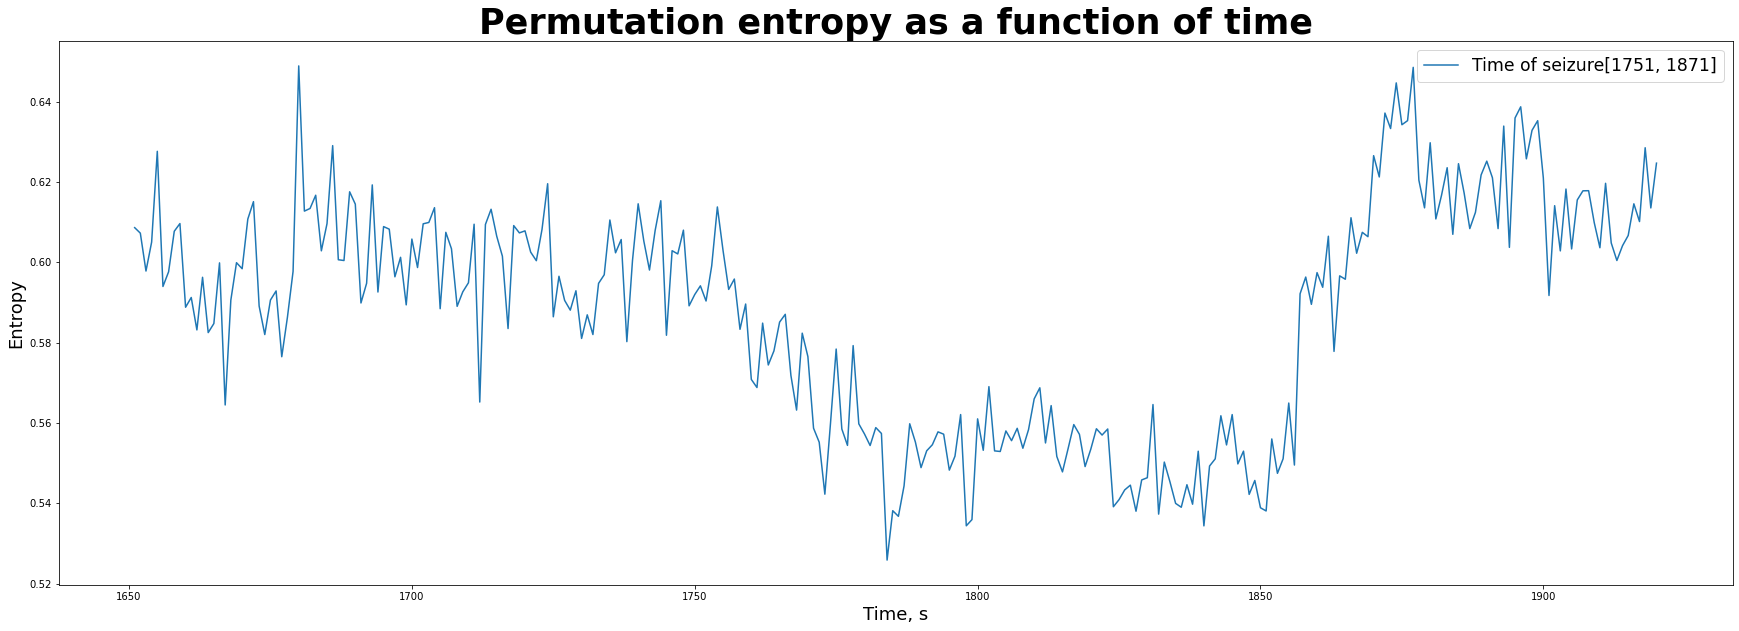

Sample: chb15-chb15_15.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751'])
Not in chb15-chb15_15.edf
Getting averaged for chb15-chb15_15.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 307
Channel: 1 F7-T7
Length of resulting signal entropy: 307
Channel: 2 T7-P7
Length of resulting signal entropy: 307
Channel: 3 P7-O1
Length of resulting signal entropy: 307
Channel: 4 --0
Length of resulting signal entropy: 307
Channel: 5 FP1-F3
Length of resulting signal entropy: 307
Channel: 6 F3-C3
Length of resulting signal entropy:

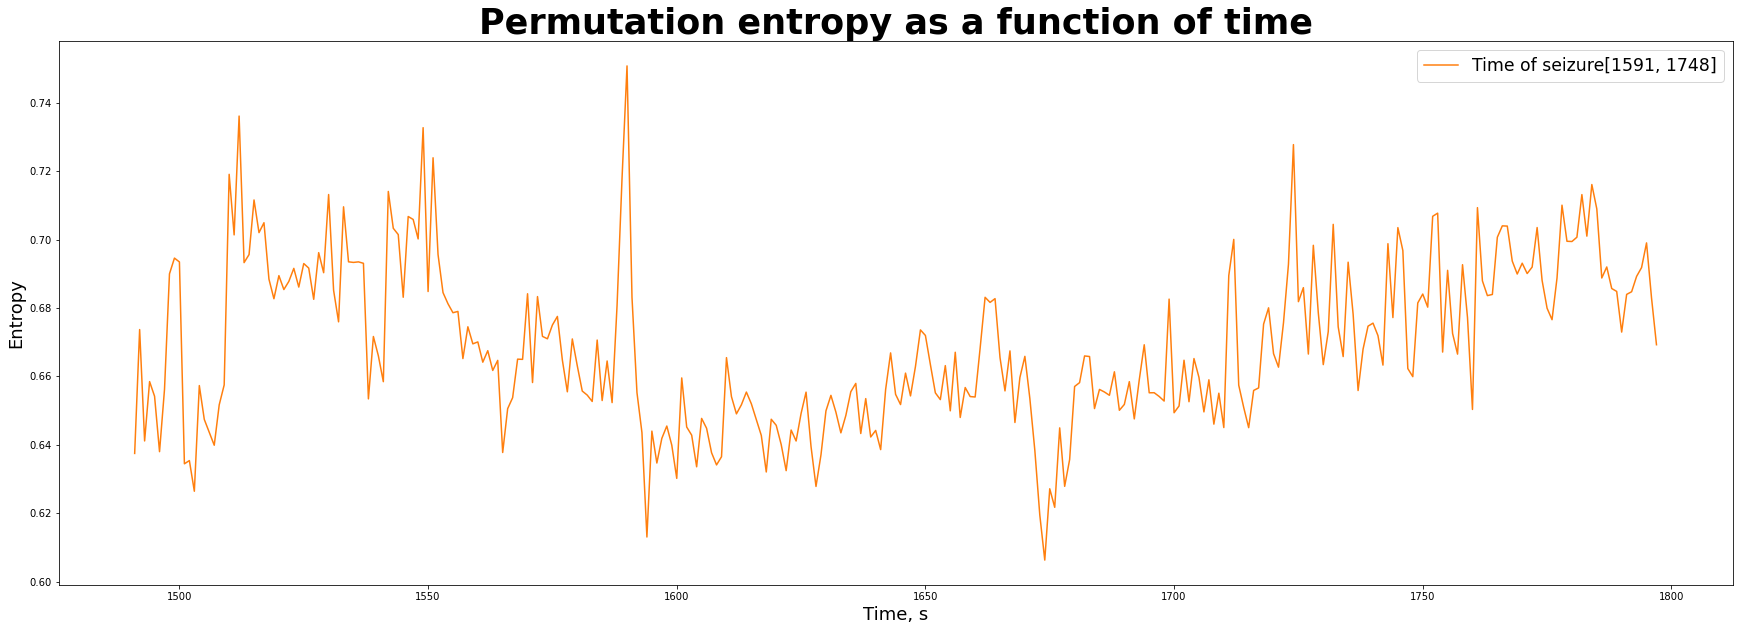

Sample: chb15-chb15_28.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591'])
Not in chb15-chb15_28.edf
Getting averaged for chb15-chb15_28.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 340
Channel: 1 F7-T7
Length of resulting signal entropy: 340
Channel: 2 T7-P7
Length of resulting signal entropy: 340
Channel: 3 P7-O1
Length of resulting signal entropy: 340
Channel: 4 --0
Length of resulting signal entropy: 340
Channel: 5 FP1-F3
Length of resulting signal entropy: 340
Channel: 6 F3-C3
Length of

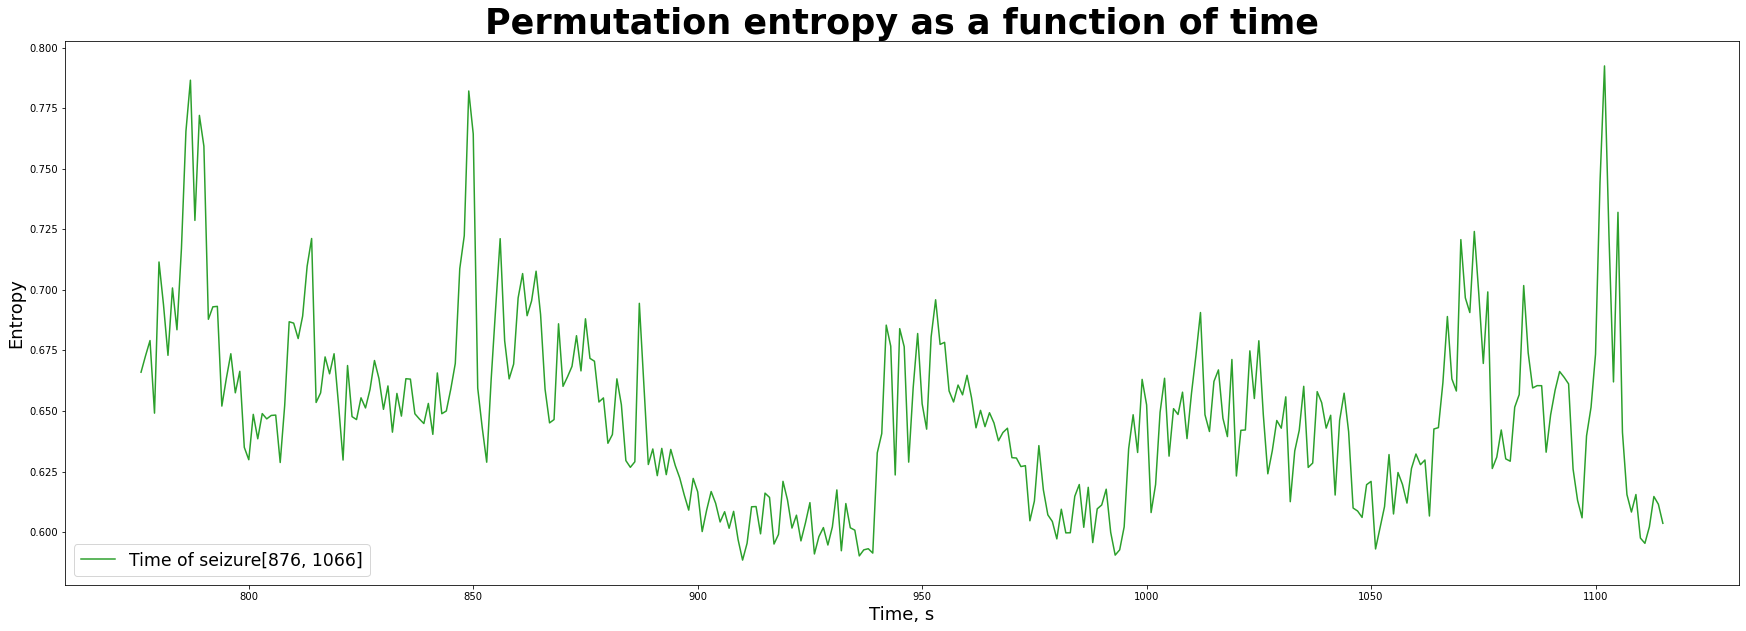

Sample: chb15-chb15_17.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876'])
Not in chb15-chb15_17.edf
Getting averaged for chb15-chb15_17.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 185
Channel: 1 F7-T7
Length of resulting signal entropy: 185
Channel: 2 T7-P7
Length of resulting signal entropy: 185
Channel: 3 P7-O1
Length of resulting signal entropy: 185
Channel: 4 --0
Length of resulting signal entropy: 185
Channel: 5 FP1-F3
Length of resulting signal entropy: 185
C

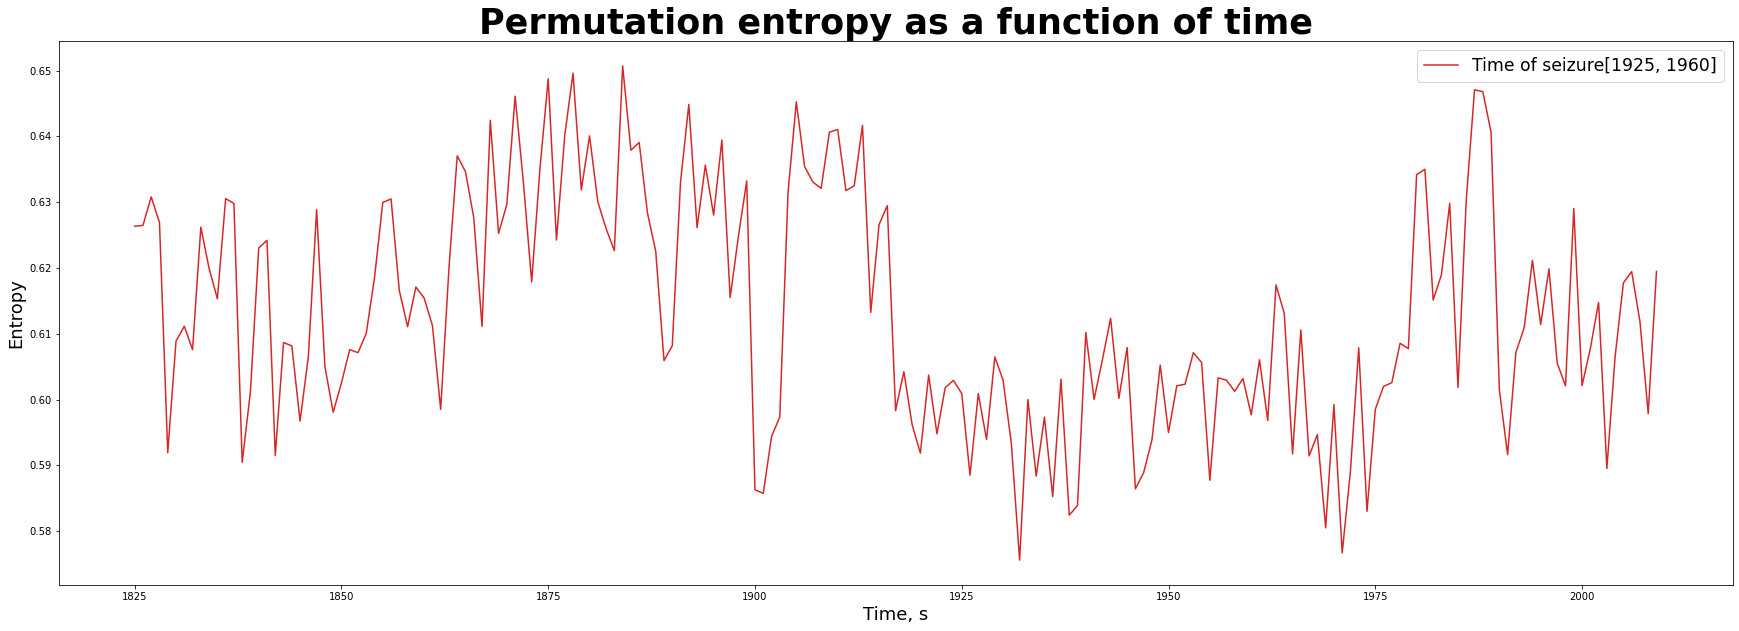

Sample: chb15-chb15_06.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925'])
Not in chb15-chb15_06.edf
Getting averaged for chb15-chb15_06.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 275
Channel: 1 F7-T7
Length of resulting signal entropy: 275
Channel: 2 T7-P7
Length of resulting signal entropy: 275
Channel: 3 P7-O1
Length of resulting signal entropy: 275
Channel: 4 --0
Length of resulting signal entropy: 275
Channel: 5 FP1-F3
Length of resul

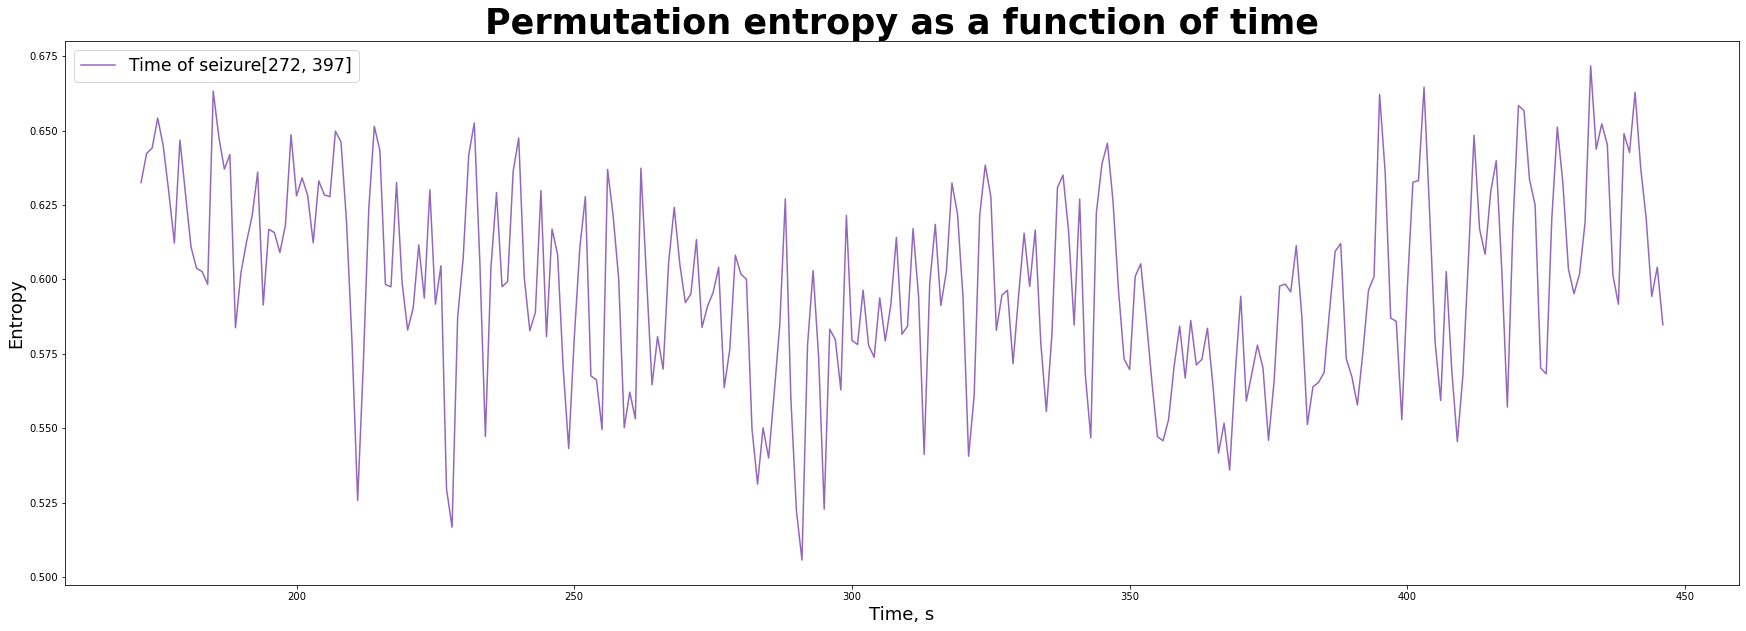

Sample: chb15-chb15_10.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272'])
Not in chb15-chb15_10.edf
Getting averaged for chb15-chb15_10.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 181
Channel: 1 F7-T7
Length of resulting signal entropy: 181
Channel: 2 T7-P7
Length of resulting signal entropy: 181
Channel: 3 P7-O1
Length of resulting signal entropy: 181
Channel: 4 --0
Length of resulting signal entropy: 181
Channel:

Sample: chb15-chb15_49.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272', 'chb15-chb15_10.edf1082'])
Not in chb15-chb15_49.edf
Getting averaged for chb15-chb15_49.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 290
Channel: 1 F7-T7
Length of resulting signal entropy: 290
Channel: 2 T7-P7
Length of resulting signal entropy: 290
Channel: 3 P7-O1
Length of resulting signal entropy: 290
Channel: 4 --0
Length of resulting si

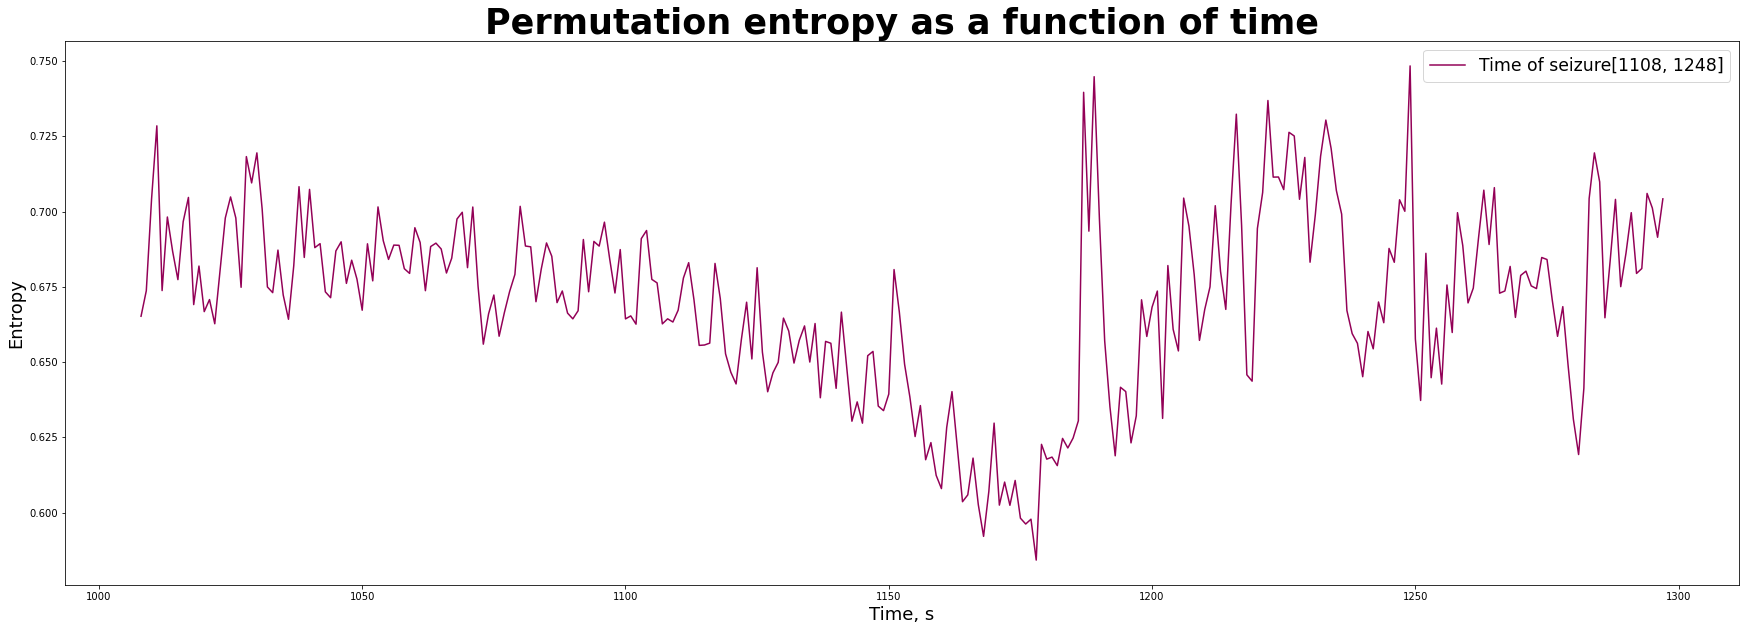

Sample: chb23-chb23_08.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272', 'chb15-chb15_10.edf1082', 'chb15-chb15_49.edf1108'])
Not in chb23-chb23_08.edf
Getting averaged for chb23-chb23_08.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 170
Channel: 1 F7-T7
Length of resulting signal entropy: 170
Channel: 2 T7-P7
Length of resulting signal entropy: 170
Channel: 3 P7-O1
Length of resulting signal entropy: 170
Channel: 4 

Sample: chb23-chb23_08.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272', 'chb15-chb15_10.edf1082', 'chb15-chb15_49.edf1108', 'chb23-chb23_08.edf325'])
Not in chb23-chb23_08.edf
Getting averaged for chb23-chb23_08.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 197
Channel: 1 F7-T7
Length of resulting signal entropy: 197
Channel: 2 T7-P7
Length of resulting signal entropy: 197
Channel: 3 P7-O1
Length of resulting signal

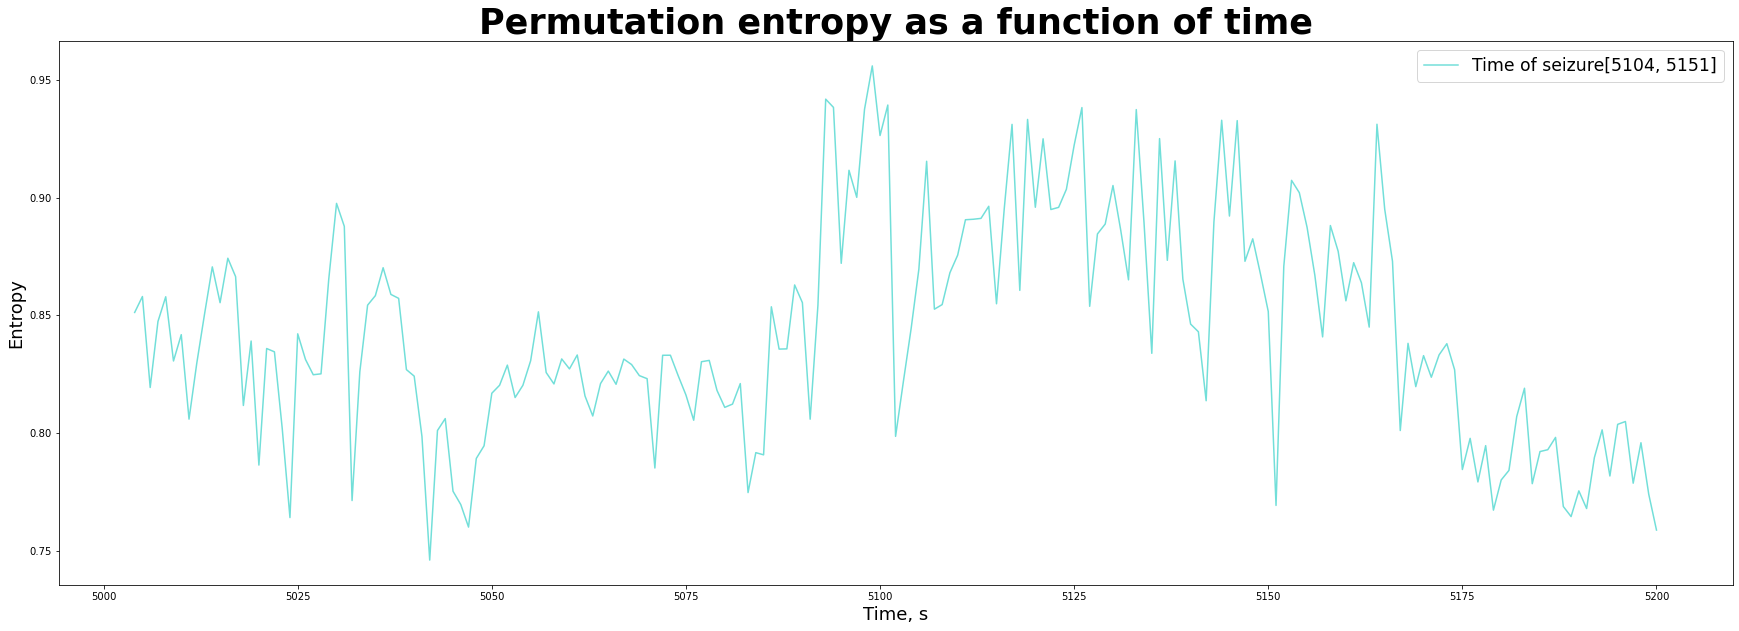

Sample: chb23-chb23_09.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272', 'chb15-chb15_10.edf1082', 'chb15-chb15_49.edf1108', 'chb23-chb23_08.edf325', 'chb23-chb23_08.edf5104'])
Not in chb23-chb23_09.edf
Getting averaged for chb23-chb23_09.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 221
Channel: 1 F7-T7
Length of resulting signal entropy: 221
Channel: 2 T7-P7
Length of resulting signal entropy: 221
Channel: 3 P7-O1


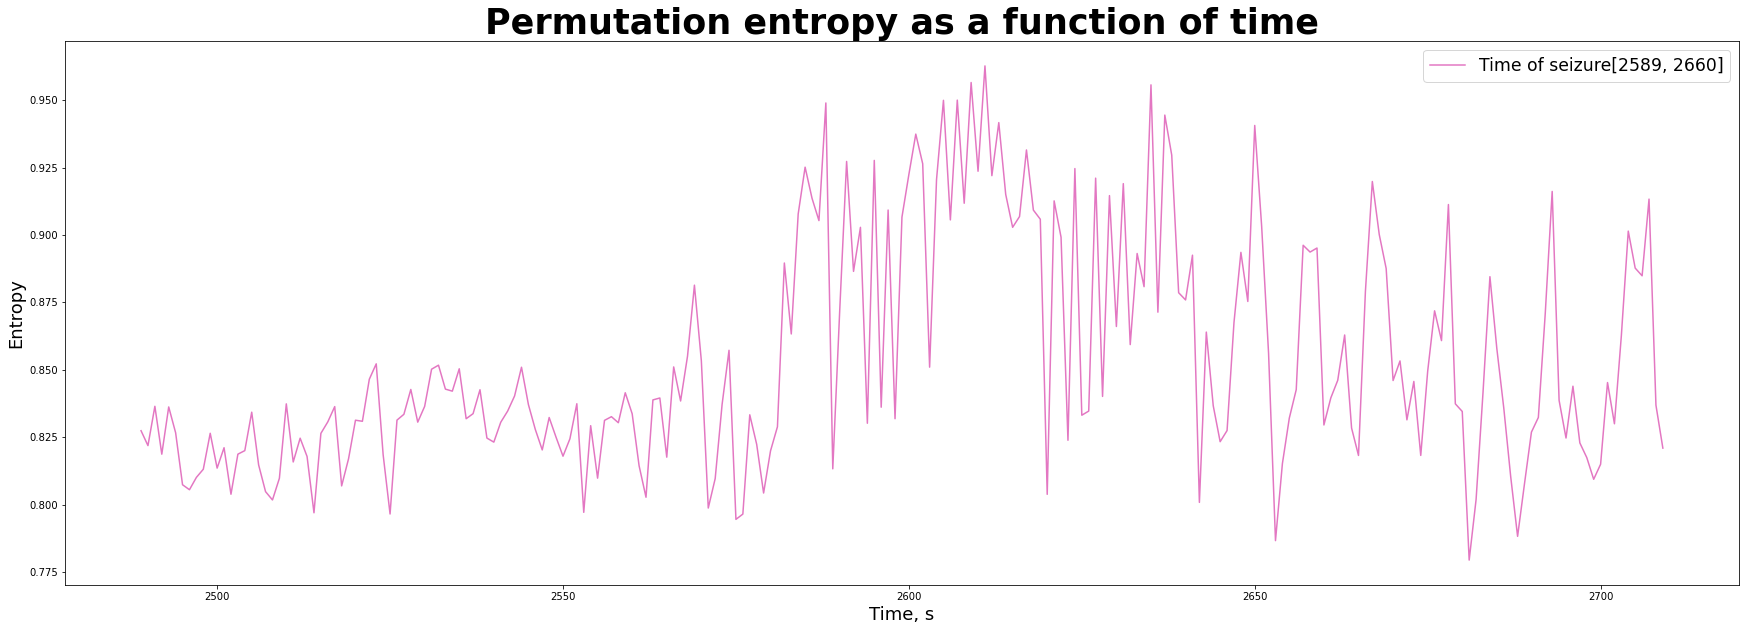

Sample: chb23-chb23_09.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272', 'chb15-chb15_10.edf1082', 'chb15-chb15_49.edf1108', 'chb23-chb23_08.edf325', 'chb23-chb23_08.edf5104', 'chb23-chb23_09.edf2589'])
Not in chb23-chb23_09.edf
Getting averaged for chb23-chb23_09.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 212
Channel: 1 F7-T7
Length of resulting signal entropy: 212
Channel: 2 T7-P7
Length of resulting signal entr

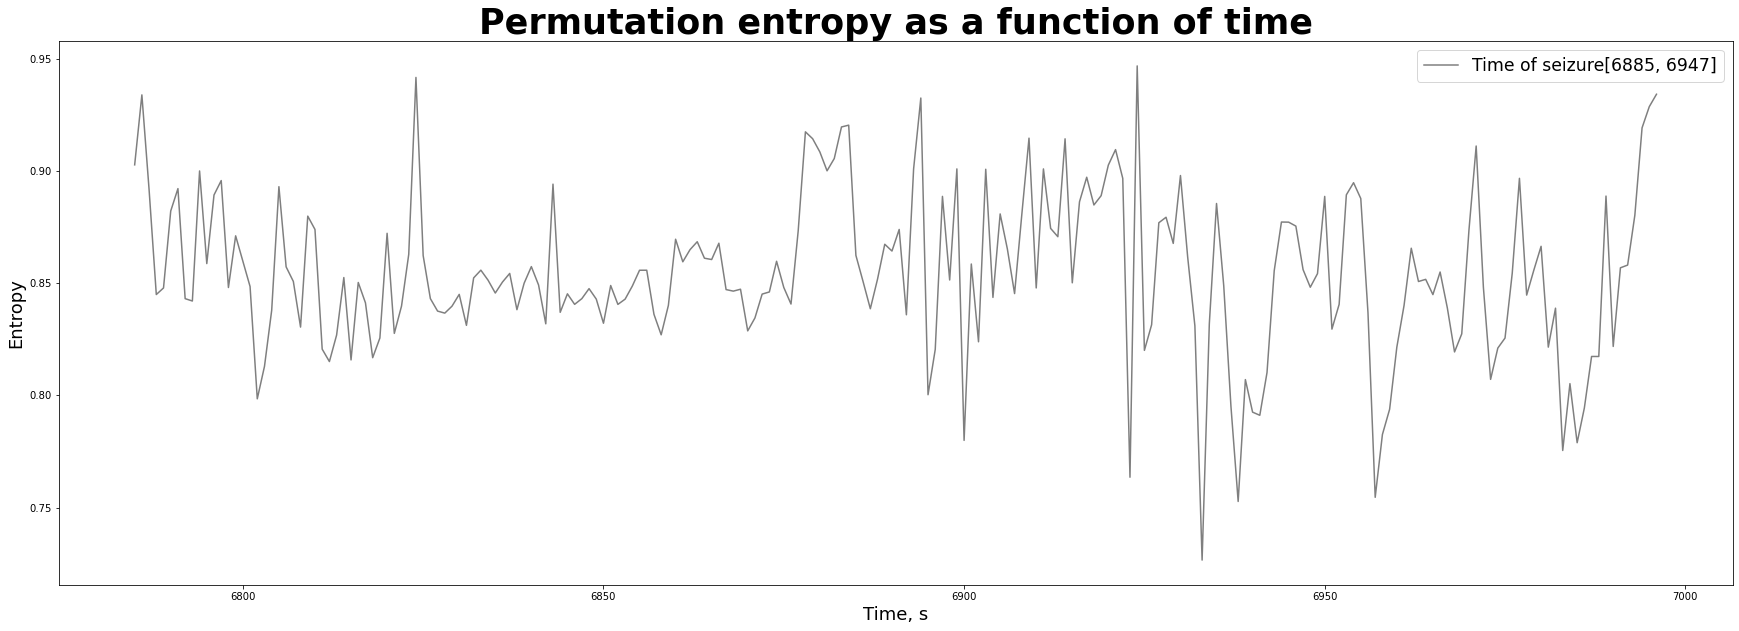

Sample: chb23-chb23_09.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272', 'chb15-chb15_10.edf1082', 'chb15-chb15_49.edf1108', 'chb23-chb23_08.edf325', 'chb23-chb23_08.edf5104', 'chb23-chb23_09.edf2589', 'chb23-chb23_09.edf6885'])
Not in chb23-chb23_09.edf
Getting averaged for chb23-chb23_09.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 177
Channel: 1 F7-T7
Length of resulting signal entropy: 177
Channel: 2 T7-P7
Lengt

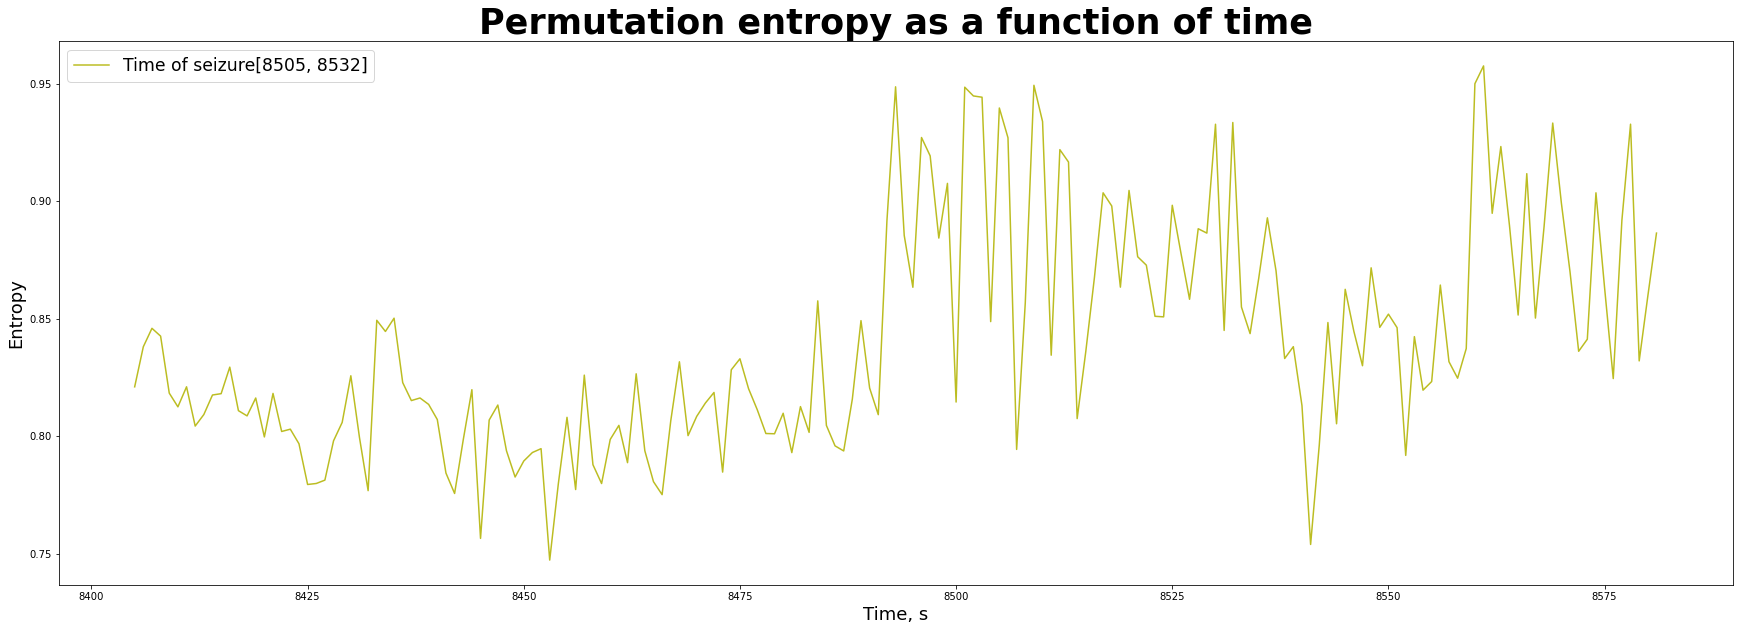

Sample: chb23-chb23_09.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272', 'chb15-chb15_10.edf1082', 'chb15-chb15_49.edf1108', 'chb23-chb23_08.edf325', 'chb23-chb23_08.edf5104', 'chb23-chb23_09.edf2589', 'chb23-chb23_09.edf6885', 'chb23-chb23_09.edf8505'])
Not in chb23-chb23_09.edf
Getting averaged for chb23-chb23_09.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 234
Channel: 1 F7-T7
Length of resulting signal entropy: 

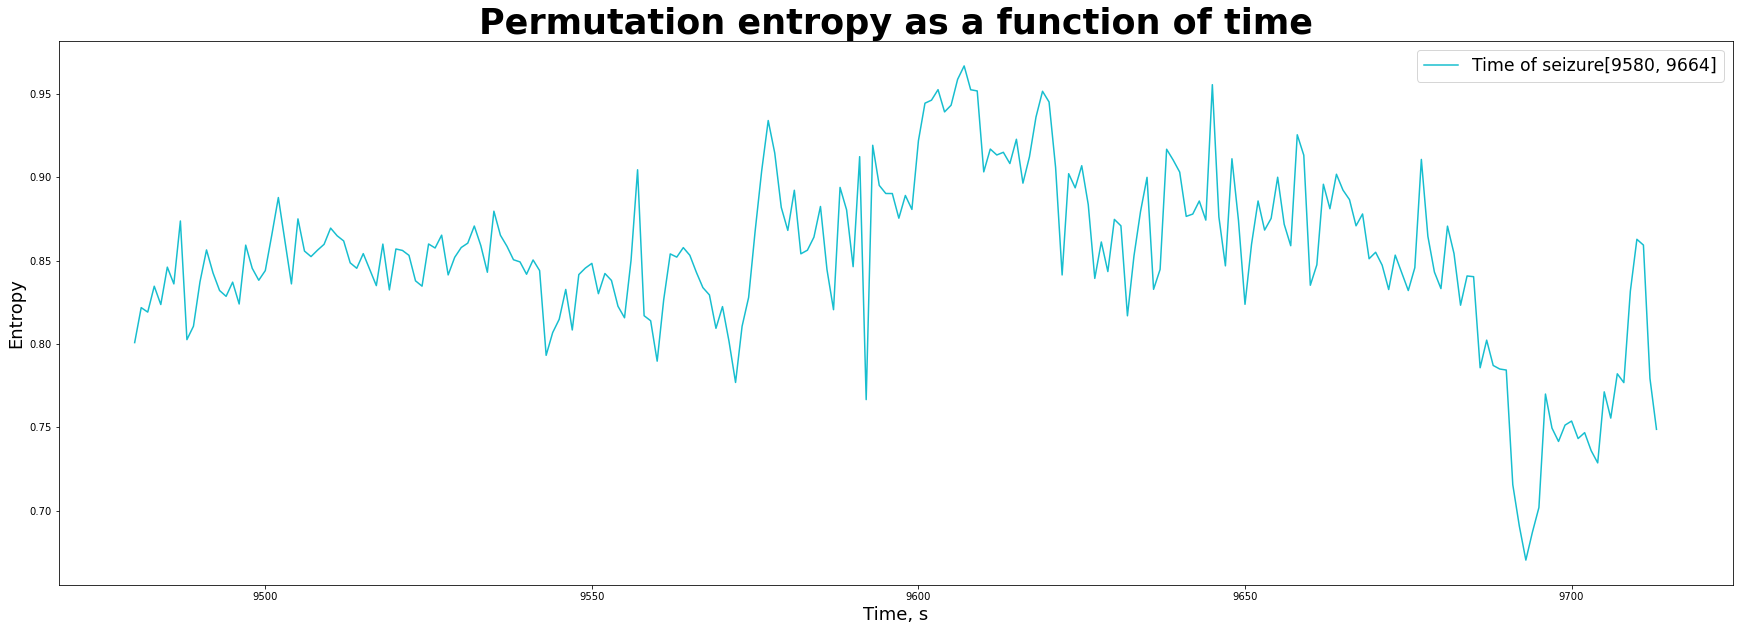

Sample: chb23-chb23_06.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272', 'chb15-chb15_10.edf1082', 'chb15-chb15_49.edf1108', 'chb23-chb23_08.edf325', 'chb23-chb23_08.edf5104', 'chb23-chb23_09.edf2589', 'chb23-chb23_09.edf6885', 'chb23-chb23_09.edf8505', 'chb23-chb23_09.edf9580'])
Not in chb23-chb23_06.edf
Getting averaged for chb23-chb23_06.edf
Channel: 0 FP1-F7
Length of resulting signal entropy: 263
Channel: 1 F7-T7
Length of 

Length of resulting signal entropy: 221
Channel: 4 FP1-F3
Length of resulting signal entropy: 221
Channel: 5 F3-C3
Length of resulting signal entropy: 221
Channel: 6 C3-P3
Length of resulting signal entropy: 221
Channel: 7 P3-O1
Length of resulting signal entropy: 221
Channel: 8 FP2-F4
Length of resulting signal entropy: 221
Channel: 9 F4-C4
Length of resulting signal entropy: 221
Channel: 10 C4-P4
Length of resulting signal entropy: 221
Channel: 11 P4-O2
Length of resulting signal entropy: 221
Channel: 12 FP2-F8
Length of resulting signal entropy: 221
Channel: 13 F8-T8
Length of resulting signal entropy: 221
Channel: 14 T8-P8-0
Length of resulting signal entropy: 221
Channel: 15 P8-O2
Length of resulting signal entropy: 221
Channel: 16 FZ-CZ
Length of resulting signal entropy: 221
Channel: 17 CZ-PZ
Length of resulting signal entropy: 221
Channel: 18 P7-T7
Length of resulting signal entropy: 221
Channel: 19 T7-FT9
Length of resulting signal entropy: 221
Channel: 20 FT9-FT10
Length of r

Length of resulting signal entropy: 251
Channel: 20 FT9-FT10
Length of resulting signal entropy: 251
Channel: 21 FT10-T8
Length of resulting signal entropy: 251
Channel: 22 T8-P8-1
Length of resulting signal entropy: 251
Len entropy 251 1963 1862
WEird error
251 251
Sample: chb01-chb01_21.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14.edf1971', 'chb15-chb15_40.edf834', 'chb15-chb15_40.edf2378', 'chb15-chb15_40.edf3362', 'chb15-chb15_52.edf778', 'chb15-chb15_46.edf3322', 'chb15-chb15_20.edf607', 'chb15-chb15_22.edf760', 'chb15-chb15_31.edf1751', 'chb15-chb15_15.edf1591', 'chb15-chb15_28.edf876', 'chb15-chb15_17.edf1925', 'chb15-chb15_06.edf272', 'chb15-chb15_10.edf1082', 'chb15-chb15_49.edf1108', 'chb23-chb23_08.edf325', 'chb23-chb23_08

Length of resulting signal entropy: 201
Channel: 1 F7-T7
Length of resulting signal entropy: 201
Channel: 2 T7-P7
Length of resulting signal entropy: 201
Channel: 3 P7-O1
Length of resulting signal entropy: 201
Channel: 4 FP1-F3
Length of resulting signal entropy: 201
Channel: 5 F3-C3
Length of resulting signal entropy: 201
Channel: 6 C3-P3
Length of resulting signal entropy: 201
Channel: 7 P3-O1
Length of resulting signal entropy: 201
Channel: 8 FP2-F4
Length of resulting signal entropy: 201
Channel: 9 F4-C4
Length of resulting signal entropy: 201
Channel: 10 C4-P4
Length of resulting signal entropy: 201
Channel: 11 P4-O2
Length of resulting signal entropy: 201
Channel: 12 FP2-F8
Length of resulting signal entropy: 201
Channel: 13 F8-T8
Length of resulting signal entropy: 201
Channel: 14 T8-P8-0
Length of resulting signal entropy: 201
Channel: 15 P8-O2
Length of resulting signal entropy: 201
Channel: 16 FZ-CZ
Length of resulting signal entropy: 201
Channel: 17 CZ-PZ
Length of resultin

Length of resulting signal entropy: 170
Channel: 9 F4-C4
Length of resulting signal entropy: 170
Channel: 10 C4-P4
Length of resulting signal entropy: 170
Channel: 11 P4-O2
Length of resulting signal entropy: 170
Channel: 12 FP2-F8
Length of resulting signal entropy: 170
Channel: 13 F8-T8
Length of resulting signal entropy: 170
Channel: 14 T8-P8-0
Length of resulting signal entropy: 170
Channel: 15 P8-O2
Length of resulting signal entropy: 170
Channel: 16 FZ-CZ
Length of resulting signal entropy: 170
Channel: 17 CZ-PZ
Length of resulting signal entropy: 170
Channel: 18 P7-T7
Length of resulting signal entropy: 170
Channel: 19 T7-FT9
Length of resulting signal entropy: 170
Channel: 20 FT9-FT10
Length of resulting signal entropy: 170
Channel: 21 FT10-T8
Length of resulting signal entropy: 170
Channel: 22 T8-P8-1
Length of resulting signal entropy: 170
Len entropy 170 6231 6211
WEird error
170 170
Sample: chb06-chb06_10.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20

Length of resulting signal entropy: 164
Channel: 13 F8-T8
Length of resulting signal entropy: 164
Channel: 14 T8-P8-0
Length of resulting signal entropy: 164
Channel: 15 P8-O2
Length of resulting signal entropy: 164
Channel: 16 FZ-CZ
Length of resulting signal entropy: 164
Channel: 17 CZ-PZ
Length of resulting signal entropy: 164
Channel: 18 P7-T7
Length of resulting signal entropy: 164
Channel: 19 T7-FT9
Length of resulting signal entropy: 164
Channel: 20 FT9-FT10
Length of resulting signal entropy: 164
Channel: 21 FT10-T8
Length of resulting signal entropy: 164
Channel: 22 T8-P8-1
Length of resulting signal entropy: 164
Len entropy 164 1738 1724
WEird error
164 164
Sample: chb06-chb06_01.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14

Length of resulting signal entropy: 162
Channel: 13 F8-T8
Length of resulting signal entropy: 162
Channel: 14 T8-P8-0
Length of resulting signal entropy: 162
Channel: 15 P8-O2
Length of resulting signal entropy: 162
Channel: 16 FZ-CZ
Length of resulting signal entropy: 162
Channel: 17 CZ-PZ
Length of resulting signal entropy: 162
Channel: 18 P7-T7
Length of resulting signal entropy: 162
Channel: 19 T7-FT9
Length of resulting signal entropy: 162
Channel: 20 FT9-FT10
Length of resulting signal entropy: 162
Channel: 21 FT10-T8
Length of resulting signal entropy: 162
Channel: 22 T8-P8-1
Length of resulting signal entropy: 162
Len entropy 162 7811 7799
WEird error
162 162
Sample: chb06-chb06_24.edf
dict_keys(['chb09_19.edf', 'chb09_08.edf', 'chb09_06.edf', 'chb20-chb20_68.edf', 'chb20-chb20_13.edf', 'chb20-chb20_68.edf1393', 'chb20-chb20_13.edf1440', 'chb20-chb20_13.edf2498', 'chb20-chb20_12.edf94', 'chb20-chb20_16.edf2226', 'chb20-chb20_15.edf390', 'chb20-chb20_15.edf1689', 'chb20-chb20_14

<ipython-input-262-95880938e528>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(30, 10))


Length of resulting signal entropy: 166
Channel: 1 F7-T7
Length of resulting signal entropy: 166
Channel: 2 T7-P7
Length of resulting signal entropy: 166
Channel: 3 P7-O1
Length of resulting signal entropy: 166
Channel: 4 FP1-F3
Length of resulting signal entropy: 166
Channel: 5 F3-C3
Length of resulting signal entropy: 166
Channel: 6 C3-P3
Length of resulting signal entropy: 166
Channel: 7 P3-O1
Length of resulting signal entropy: 166
Channel: 8 FP2-F4
Length of resulting signal entropy: 166
Channel: 9 F4-C4
Length of resulting signal entropy: 166
Channel: 10 C4-P4
Length of resulting signal entropy: 166
Channel: 11 P4-O2
Length of resulting signal entropy: 166
Channel: 12 FP2-F8
Length of resulting signal entropy: 166
Channel: 13 F8-T8
Length of resulting signal entropy: 166
Channel: 14 T8-P8-0
Length of resulting signal entropy: 166
Channel: 15 P8-O2
Length of resulting signal entropy: 166
Channel: 16 FZ-CZ
Length of resulting signal entropy: 166
Channel: 17 CZ-PZ
Length of resultin

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

In [262]:
i = 0
import json
for sample in samples:
    print('Sample:', sample.file)
    try:
        with open('entropy_window=1, m=4, lag=1.txt') as json_file:
            data = json.load(json_file)
            print(data.keys())
    except FileNotFoundError:
        print("The permutation entropy is not calculated for such parameters yet")
        
    if sample.file+str(sample.seizure_time[0]) not in data.keys():
        print("Not in",sample.file)
        entropy = sample.get_averaged_permutation_entropy(1,4,1)
        print("Len entropy", len(entropy), sample.seizure_time[1], sample.seizure_time[0] )
        
        sample.averaged_entropy['window=1, m=4, lag=1'] = entropy
        averaged_entropy[sample.file+str(sample.seizure_time[0])] = entropy
        data[sample.file+str(sample.seizure_time[0])] = entropy
        with open('entropy_window=1, m=4, lag=1.txt', 'w') as outfile:
            json.dump(averaged_entropy, outfile)
    else:
        # reading from the file
        print("In")
        entropy = data[sample.file+str(sample.seizure_time[0])]
        print("Equals test", entropy==sample.get_averaged_permutation_entropy(1,4,1))
        print(sample.file+str(sample.seizure_time[0]))
        
        averaged_entropy[sample.file+str(sample.seizure_time[0])] = entropy
#         sample.averaged_entropy['window=1, m=4, lag=1'] = entropy
        
    time_ = np.arange(sample.seizure_time[0] - sample.window_before, sample.seizure_time[1] + sample.window_after, 1)

    fig = plt.figure(figsize=(30, 10))
    try:
        plt.plot(time_, averaged_entropy[sample.file+str(sample.seizure_time[0])], COLORS[i], label="Time of seizure"+str(sample.seizure_time))
        i += 1
        plt.xlabel('Time, s', fontsize=18)
        plt.ylabel('Entropy', fontsize=18)
        plt.title('Permutation entropy as a function of time', weight='bold', fontsize=35)
        plt.legend(fontsize='xx-large')
        plt.show()
        
        
    except:
        print("Error due to lack of data on some points in the vector")
        print(len(time_), len(averaged_entropy[sample.file+str(sample.seizure_time[0])]))

For a particular sample chb09_19.edf PE begins to decrease significantly both at the beginning and at the end of a signal. 
I will use some quantification metric that will inform about significance of decrease of PE. If that metric will be less than a particular value, then I will say that PE changes significantly. 

The following function predicts the time of the start of the seizure based on the PE data. 
It goes through the PE of the given signal with window length = 10 seconds, iteratively with 1 second shift. It extracts the data of permutation entropy for that 10 seconds and tries to fit the line to them. Based on the slope coefficient I find out how is the PE entropy changing regarding to time. If the slope is more than k_boundary value than the change is PE is said to be significant enough for considering the seizure to happen soon. 

In [ ]:
len([i for i in averaged_entropy.values()])

In [126]:
from sklearn.linear_model import LinearRegression

slopes={}
def staring_seizure_extraction_using_sample(sample, len_window, len_step, k_boundary):
    '''
    sample --> EEG_sample
    len_window, len_step --> int
    k_boundary --> float
    '''
    pe_ = sample.averaged_entropy['window=1, m=4, lag=1']
    slopes[(len_window, len_step)] = []
    end_seizure = str(len(pe_)-sample.window_after)
    fig = plt.figure(figsize=(40, 10))
    time_ = np.arange(0, len(pe_), 1)
    plt.plot(time_, pe_, 'o')
#     plt.show()
    
    for i in range(0, len(pe_)-len_window, len_step):
        x = np.array([j for j in range(len_window)])
        y = np.array([pe_[j] for j in range(i, i+len_window)])
        
        m, b = np.polyfit(x, y, 1)
        time_2 = [j for j in range(i, i+len_window)]
        plt.plot(time_2, m*x + b)
        slopes[(len_window, len_step)].append(m)
        
    plt.axvline(x=sample.window_before)
    plt.axvline(x=len(pe_)-sample.window_after)
    plt.xlabel('Time, s', fontsize=18)
    plt.ylabel('Entropy', fontsize=18)
    plt.title("PE calculated with the following params: window=1, m=4, lag=1" , weight='bold', fontsize=35)
    plt.show()
        
        

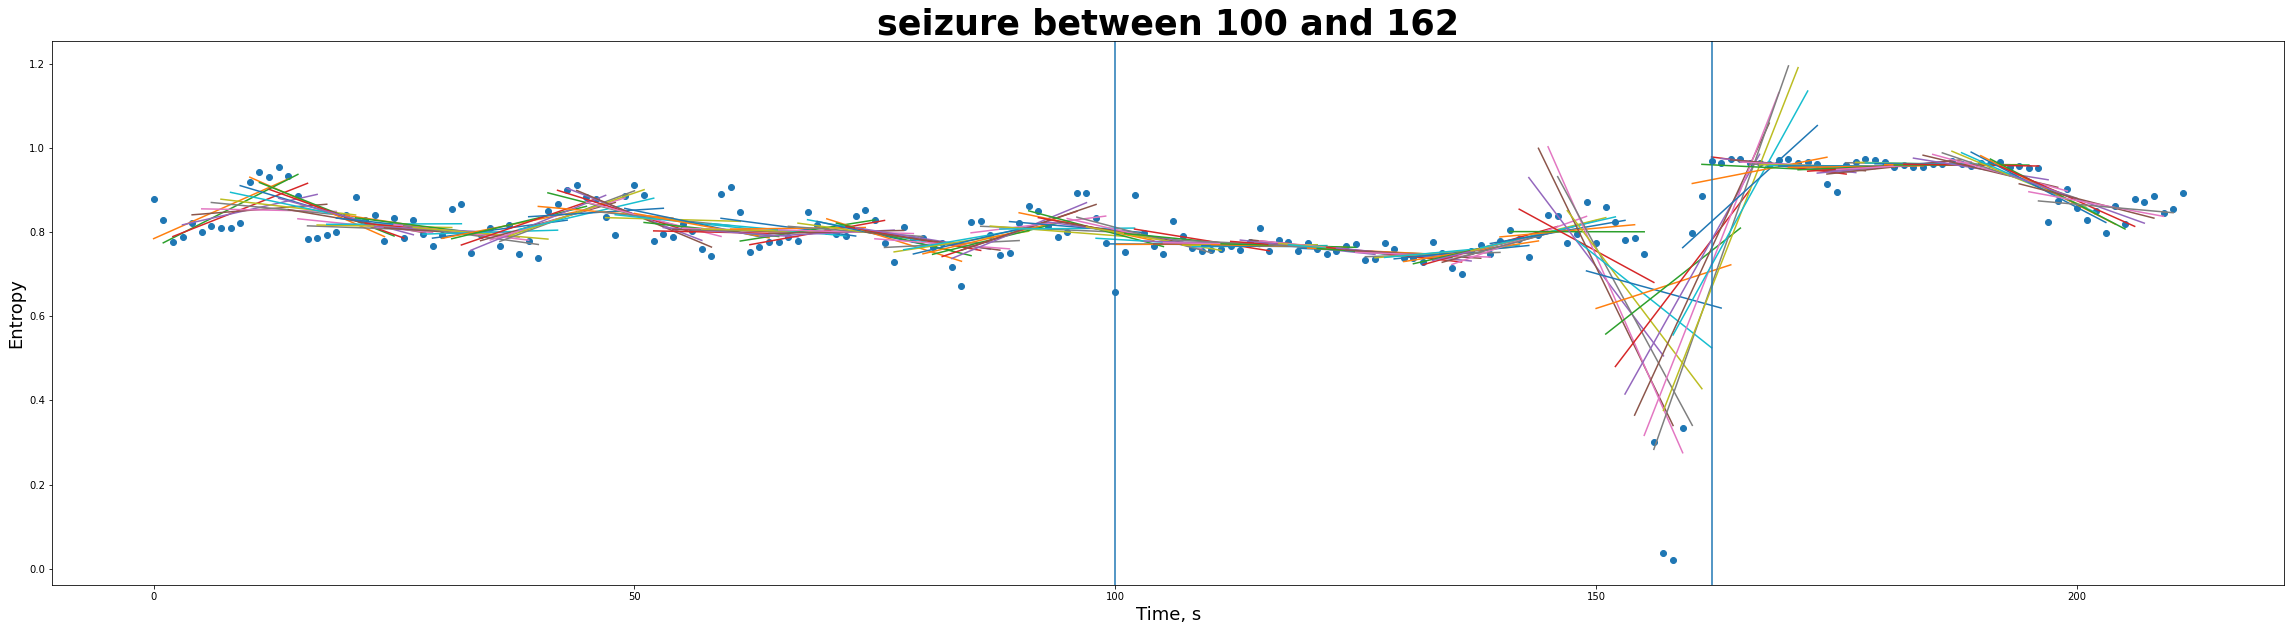

In [112]:
staring_seizure_extraction(averaged_entropy['chb09_19.edf'], 15, 1, 0.)

In [113]:
min(slopes[(15,1)]), max(slopes[(15,1)]), slopes[(15,1)].index(min(slopes[(15,1)])), slopes[(15,1)].index(max(slopes[(15,1)]))

(-0.051955167570698985, 0.06511446999817164, 145, 156)

In [ ]:
 len(averaged_entropy['chb09_19.edf'])-150

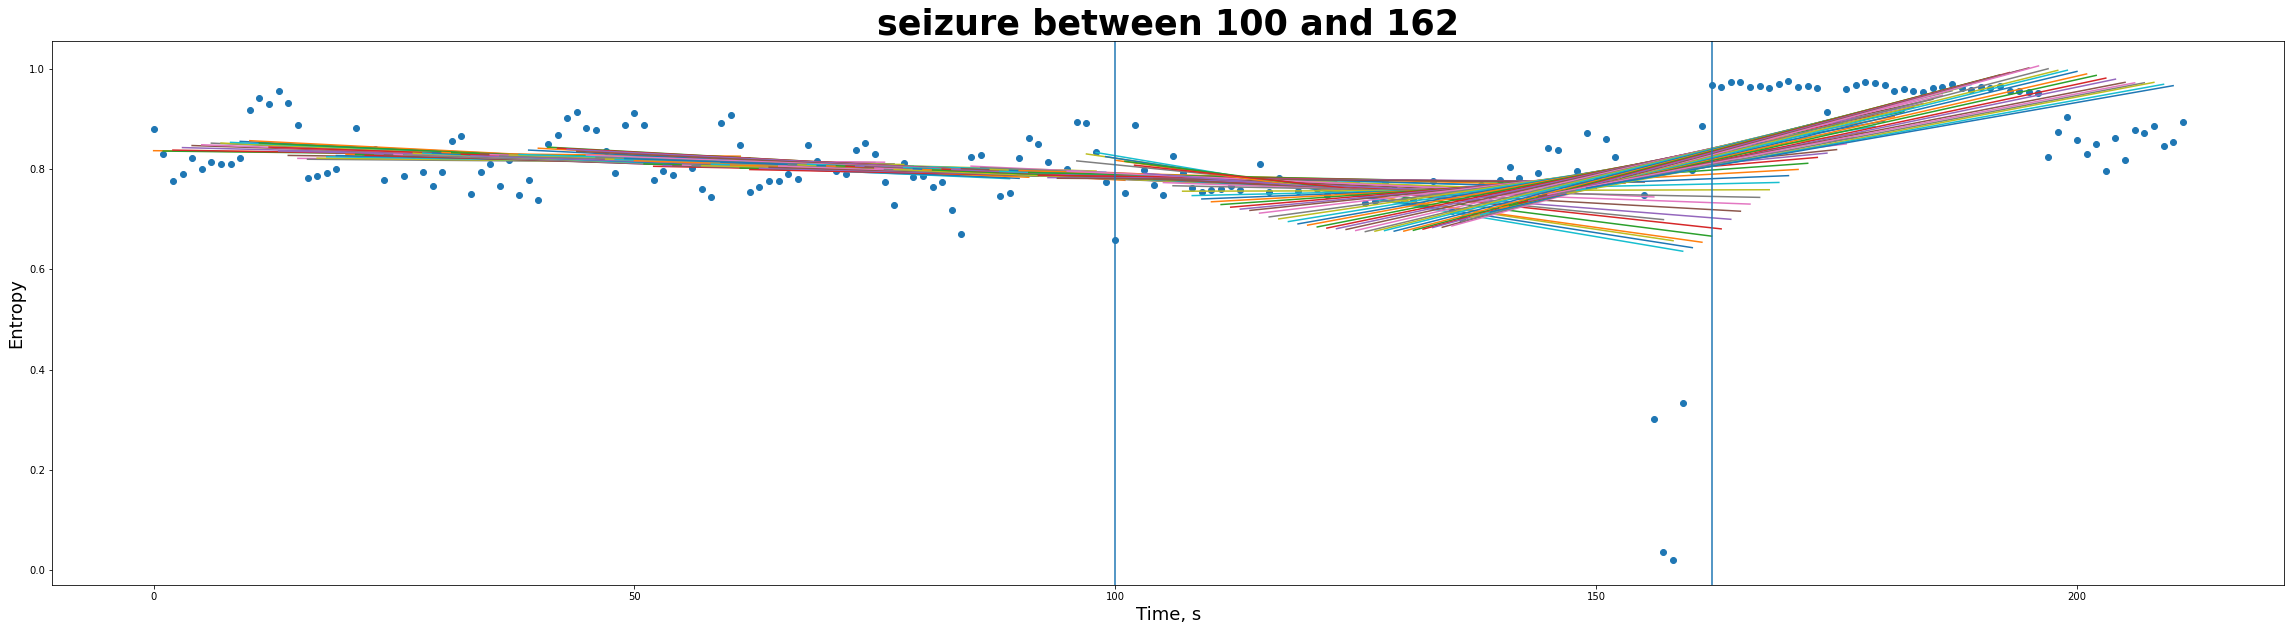

In [114]:
seizure_len = len(averaged_entropy['chb09_19.edf'])-150
staring_seizure_extraction(averaged_entropy['chb09_19.edf'], seizure_len, 1, 0.)

In [121]:
min(slopes[(seizure_len, 1)]), max(slopes[(seizure_len, 1)]), slopes[(seizure_len, 1)].index(min(slopes[(seizure_len, 1)])), slopes[(seizure_len, 1)].index(max(slopes[(seizure_len, 1)]))+seizure_len




(-0.0032282221328036615, 0.005231629619108615, 98, 197)

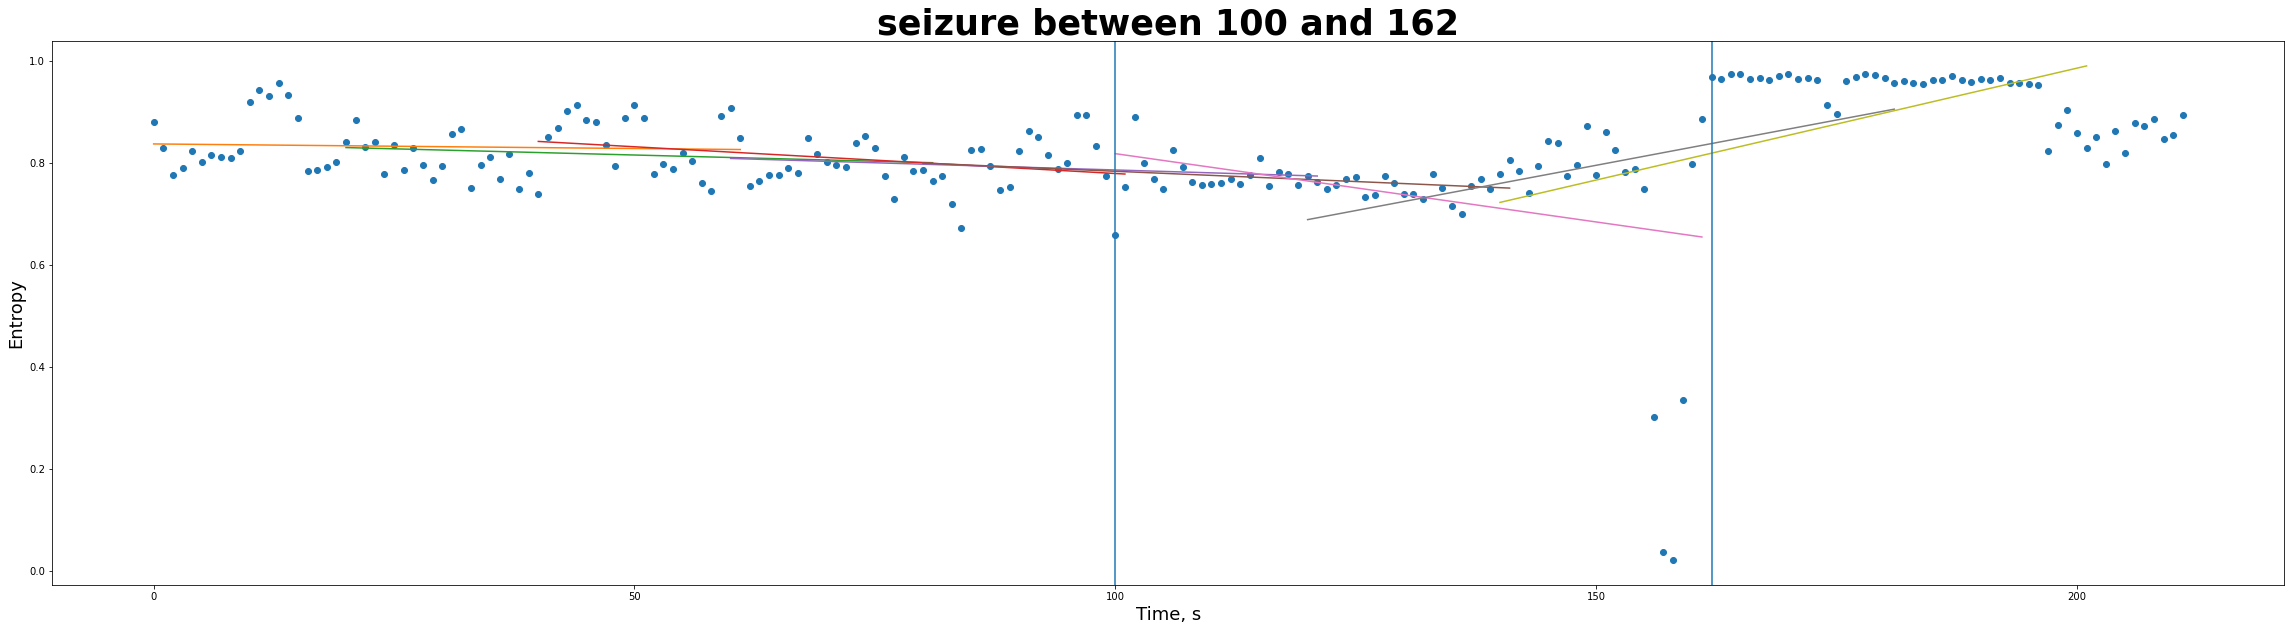

In [122]:
seizure_len = len(averaged_entropy['chb09_19.edf'])-150
staring_seizure_extraction(averaged_entropy['chb09_19.edf'], seizure_len, seizure_len//3, 0.)

In [123]:
min(slopes[(seizure_len, seizure_len//3)]), max(slopes[(seizure_len, seizure_len//3)]), slopes[(seizure_len, seizure_len//3)].index(min(slopes[(seizure_len, seizure_len//3)]))*seizure_len//3, slopes[(seizure_len, seizure_len//3)].index(max(slopes[(seizure_len, seizure_len//3)]))*seizure_len//3 + seizure_len





(-0.0026794029809717825, 0.004389435011526821, 103, 206)

Зі збільшенням тривалості зсувного вікна та кількості точок, використаних для наближення лінійною регресією, зменшується абсолютне значення максимального та мінімального коефіцієнта нахилу, тобто наближення стає менш точним. 

# Оптимізуємо гіперпараметри -- значення тривалості вікна та зсуву так щоб помилка при розрахунку початку епілептичного нападу була найменшою.

In [218]:
def staring_seizure_extraction_using_pe_vector(search_space):
    '''
    pe_ --> list
    len_window, len_step --> int
    k_boundary --> float
    '''
    pe_ = aes[search_space['pe_']]
#     print("Pe", type(pe_), len(pe_))
    len_window = search_space['len_window']
    len_step = search_space['len_step']
    
    slopes = []
    end_seizure = str(len(pe_)-50)
    
    for i in range(0, len(pe_)-len_window, len_step):
        x = np.array([j for j in range(len_window)]).reshape(-1, 1)
        y = np.array([pe_[j] for j in range(i, i+len_window)])
        
#         m, b = np.polyfit(x, y, 1)
        lr = LinearRegression().fit(x,y)
        m = lr.coef_[0]
        slopes.append(m)
    
    return np.abs(100-start)


In [219]:
# !pip install hyperopt
aes = []
for i in averaged_entropy.values():
    aes.append(tuple(i))
    
aes = np.asarray(aes)
    

In [220]:
from hyperopt import fmin, hp, tpe

In [428]:
import numpy as np
from sklearn.linear_model import LinearRegression
from hyperopt import fmin, hp, tpe
# from scipy.optimize import fmin
class Predictor:
    def __init__(self):
        self.fitted = False

    def fit(self, list_of_samples):
        raise NotImplementedError

    def predict(self, list_):
        raise NotImplementedError

    def predict(self, sample):
        raise NotImplementedError

class PermutationEntropyPredictor(Predictor):
    def __init__(self):
        super(PermutationEntropyPredictor, self).__init__()
        self.best = None


    def fit(self, list_of_samples):
        
        def predict_time_based_on_pe(pe, window, step, k_boundary):
#             print("Params:",window, step, k_boundary)
            if step == 0:
                return -1000
            
            if len(range(0, len(pe) - window, step)) == 0:
                return -1000
            
            slopes = []
            for i in range(0, len(pe) - window, step):
                x = np.array([j for j in range(window)]).reshape(-1, 1)
                y = np.array([pe[j] for j in range(i, i + window)])
                
                lr = LinearRegression().fit(x, y)
                m = lr.coef_[0]
                slopes.append(m)
            
            counts_time = []
            for i, slope in enumerate(slopes):
                if np.abs(slope) > k_boundary:
                    counts_time.append(i)
            if len(counts_time) == 0:
                m_ = slopes.index(max(slopes))
            else:
                m_ = max(counts_time)
                
            return m_*step

        def _predict_time(search_space):

            window = search_space['window']
            step = search_space['step']
            k_boundary = search_space['k_boundary']

            errors = []
            for sample in list_of_samples:
                start_time = sample.seizure_time[0]
                pe = sample.averaged_entropy['window=1, m=4, lag=1']
                predicted_time = predict_time_based_on_pe(pe, window, step, k_boundary)
                error = np.abs(start_time - predicted_time)
                errors.append(error)

            return sum(errors)/len(errors)

        search_space = {
                'window': hp.choice('window', np.arange(1, 100,1, dtype=int)),
                'step': hp.choice('step', np.arange(1, 100, 1, dtype=int)),
            'k_boundary': hp.lognormal('k_boundary', 0, 1)
        }
        algo = tpe.suggest
        self.best = fmin(fn=_predict_time,
            space=search_space,
            algo=algo,
            max_evals=300)
        
    def predict(self, list_):
        def predict_time_based_on_pe(pe, window, step, k_boundary):
            if step == 0:
                return -1000
            
            if len(range(0, len(pe) - window, step)) == 0:
                return -1000
            
            slopes = []
            for i in range(0, len(pe) - window, step):
                x = np.array([j for j in range(window)]).reshape(-1, 1)
                y = np.array([pe[j] for j in range(i, i + window)])
                
                lr = LinearRegression().fit(x, y)
                m = lr.coef_[0]
                slopes.append(m)
            
            counts_time = []
            for i, slope in enumerate(slopes):
                if np.abs(slope) > k_boundary:
                    counts_time.append(i)
                    
            if len(counts_time) == 0:
                m_ = slopes.index(max(slopes))
            else:
                m_ = max(counts_time)
                
            return m_*step


        predictions = []
        for sample in list_:
            start_time = sample.seizure_time[0]
            pe = sample.averaged_entropy['window=1, m=4, lag=1']
            predicted_time = predict_time_based_on_pe(pe, self.best['window'], self.best['step'], self.best['k_boundary'])
            predictions.append(predicted_time)
            error = np.abs(start_time - predicted_time)
#             print("Error", error)
#             print("Predicted - actual", predicted_time, start_time)
        return predictions


In [429]:
staring_seizure_extraction_using_pe_vector(best)

2

In [430]:
predictor_pe = PermutationEntropyPredictor()
predictor_pe.fit(samples)

100%|██████████| 300/300 [00:43<00:00,  6.85trial/s, best loss: 3499.16]


In [431]:
predictor_pe.best

{'k_boundary': 0.08203450357557092, 'step': 1, 'window': 2}

In [432]:
errorw = predictor_pe.predict(samples)

In [433]:
sum(errorw)/len(errorw)

135.7

In [434]:
errorw

[156,
 173,
 173,
 -1000,
 172,
 163,
 144,
 153,
 188,
 57,
 69,
 189,
 196,
 146,
 181,
 28,
 18,
 329,
 78,
 89,
 174,
 241,
 165,
 159,
 152,
 171,
 173,
 112,
 231,
 196,
 178,
 173,
 162,
 188,
 246,
 189,
 138,
 178,
 146,
 168,
 133,
 160,
 158,
 160,
 160,
 161,
 160,
 151,
 140,
 160]